# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [1]:
#!unzip -qq data/hw1_data.zip -d data/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as data

import os.path as osp
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm
from time import time
from transformers import get_cosine_schedule_with_warmup

from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    load_text_data,
    visualize_q5_data,
    q5a_save_results,
    # Q6
    load_colored_mnist_text,
    load_pretrain_vqvae,
    visualize_q6_data,
    q6a_save_results,
)
from deepul import pytorch_util
from deepul import utils

GPU_ID = 1

/home/nolan/miniforge3/envs/deepul/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


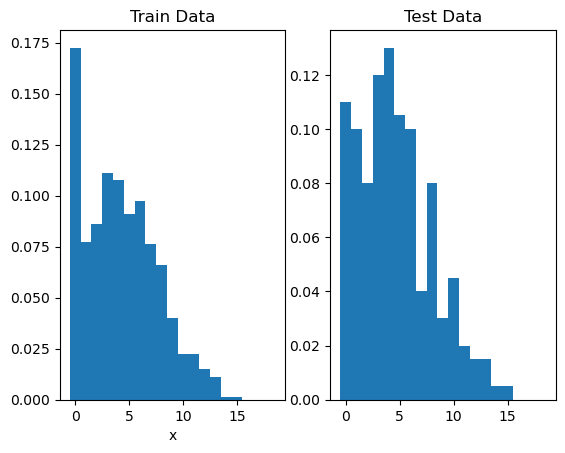

Dataset 2


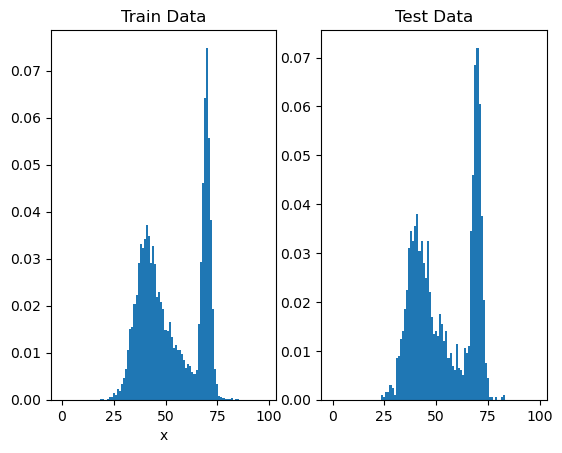

In [3]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^{d}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
train_data, test_data = q1_sample_data_1()
print(train_data[:10])
print(train_data.dtype)

[11  6  8 13 11  1  8  4  4  6]
int64


In [5]:
class Histogram(pytorch_util.MyModule):
    def __init__(self, d: int):
        super().__init__()
        self.theta = nn.Parameter(torch.zeros(d))
        self.print_n_params()

    @property
    def logits(self):
        return self.theta

    @property
    def device(self):
        return self.theta.device

    def forward(self, x: torch.Tensor):
        """
        x: (batch,)

        Returns
        - logits tensor of shape (batch, d)
        """
        return self.logits.unsqueeze(0).expand(x.shape[0], -1)

In [6]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, ..., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  pytorch_util.set_gpu_mode("cuda", GPU_ID)
  device = pytorch_util.device
  pytorch_util.seed_rng(0)

  train_data = torch.from_numpy(train_data).to(device)
  test_data = torch.from_numpy(test_data).to(device)
  train_losses, test_losses = [], []

  model = Histogram(d)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

  def evaluate():
    with torch.no_grad():
      logits = model(test_data)
      loss = F.cross_entropy(logits, test_data)
    return loss.cpu().item()

  test_losses.append(evaluate())
  epochs = 100
  for _ in tqdm(range(epochs)):
    # train loss
    for train_mbatch in train_dataloader:
      optimizer.zero_grad()
      logits = model(train_mbatch)
      loss = F.cross_entropy(logits, train_mbatch)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.cpu().item())

    # test loss
    test_losses.append(evaluate())

  with torch.no_grad():
    probs = F.softmax(model.logits, 0).cpu().numpy()

  return np.array(train_losses), np.array(test_losses), probs

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Parameter count: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 164.19it/s]


Final Test Loss: 2.5481


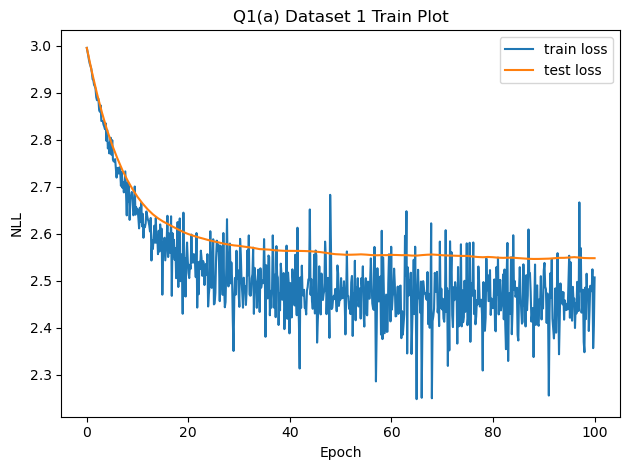

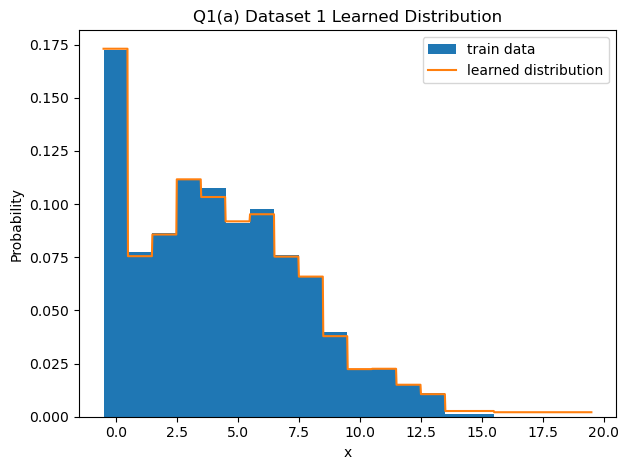

In [7]:
q1_save_results(1, 'a', q1_a)
with torch.no_grad():
    torch.cuda.empty_cache()

Parameter count: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.35it/s]


Final Test Loss: 3.6853


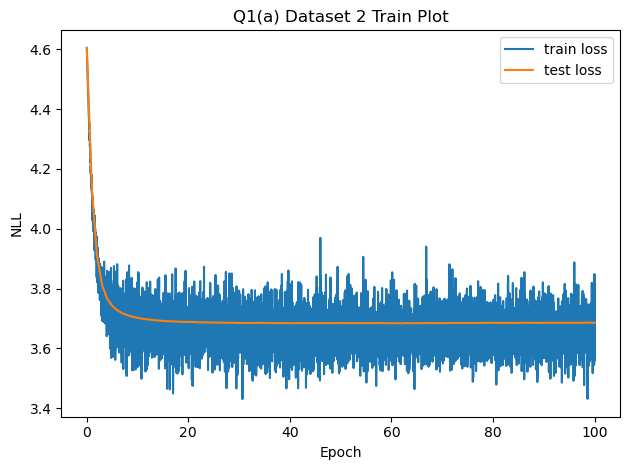

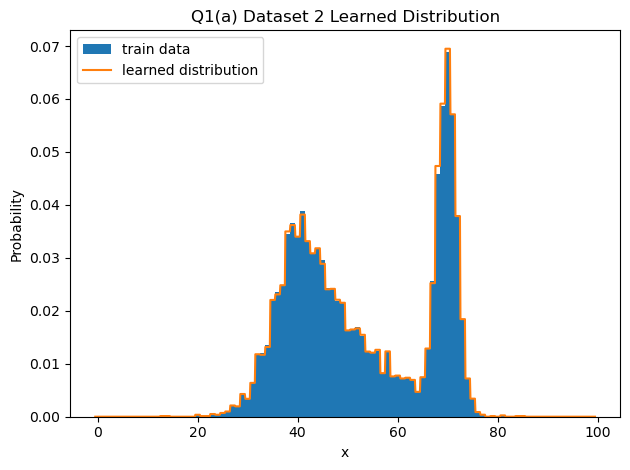

In [8]:
q1_save_results(2, 'a', q1_a)
with torch.no_grad():
    torch.cuda.empty_cache()

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

We shall derive the log-probability $\log p_\theta(x)$. Let's define the following functions:
$$
\Delta \sigma_i(x) = \begin{cases}
\sigma((x+0.5-\mu_i)/s_i), & x = 0 \\
1-\sigma((x-0.5-\mu_i)/s_i), & x = 99 \\
\sigma((x+0.5-\mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)), & \text{otherwise}.
\end{cases}
$$
We then define a weight vector $w \in \mathbb{R}^n$ such that $\pi_i = \left. e^{w_i} \middle/ \sum_j e^{w_j} \right.$. Then, the log-probability is
\begin{align*}
\log p_\theta(x) &= \log \dfrac{\displaystyle \sum_{i=1}^n e^{w_i + \log \Delta \sigma_i(x)} } {\displaystyle \sum_{i=1}^n e^{w_i}} \\
&= \log \sum_{i=1}^n e^{w_i + \log \Delta \sigma_i(x)} - \log \sum_{i=1}^n e^{w_i} .
\end{align*}
We recognize this as the difference of two log-sum-exp functions.

We shall now show that $\log \Delta \sigma_i(x)$ has the following form:
$$
\log \Delta \sigma_i(x) = \begin{cases}
\log \sigma((x+0.5-\mu_i) / s_i), & x = 0 \\
\log \sigma (-(x-0.5-\mu_i) / s_i), & x = 99 \\
-(x+0.5-\mu_i)/s_i - (\log\sigma)^{-1}(-1/s_i) + \log\sigma((x+0.5-\mu_i)/s_i) + \log\sigma((x-0.5-\mu_i)/s_i), & \text{otherwise},
\end{cases}
$$
where $(\log\sigma)^{-1}(x) = -\log(e^{-x}-1)$ (*inverse log-sigmoid function*).

For compactness, we define $\Delta x_i = x - \mu_i$. For $x = 0$, we have:
$$
\log \Delta\sigma_i(x) = \log \sigma((\Delta x_i+0.5)/s_i).
$$

Similarly, for $x = 99$, we have:
$$
\log \Delta\sigma_i(x) = \log (1 - \sigma((\Delta x_i-0.5)/s_i)) = \log \sigma(-(\Delta x_i-0.5)/s_i)),
$$
where we take advantage of the fact that $1 - \sigma(x) = \sigma(-x)$.

Finally, for $0 < x < 99$, we have:
\begin{align*}
\log \Delta\sigma_i(x) &= \log\left( \frac{1}{1 + e^{-(\Delta x_i + 0.5)/s_i}} - \frac{1}{1 + e^{-(\Delta x_i - 0.5)/s_i}} \right) \\
&= \log \frac{ e^{-(\Delta x_i - 0.5)/s_i} - e^{-(\Delta x_i + 0.5)/s_i} }{ (1 + e^{-(\Delta x_i + 0.5)/s_i}) (1 + e^{-(\Delta x_i - 0.5)/s_i}) } \\
&= -\frac{\Delta x_i + 0.5}{s_i} + \log(e^{1/s_i} - 1) + \log\sigma((\Delta x_i+0.5)/s_i) + \log\sigma((\Delta x_i-0.5)/s_i) \\
&= -\frac{\Delta x_i + 0.5}{s_i} - (\log\sigma)^{-1}(-1/s_i) + \log\sigma((\Delta x_i+0.5)/s_i) + \log\sigma((\Delta x_i-0.5)/s_i) .
\end{align*}

In [9]:
def logsigmoid_inverse(x: torch.Tensor):
    return -torch.log(torch.expm1(-x))


class DML(pytorch_util.MyModule):
    def __init__(self, n_mix: int, d: int):
        super().__init__()
        self.n_mix = n_mix
        self.d = d
        self.log_weights = nn.Parameter(torch.zeros(self.n_mix))
        self.locs = nn.Parameter(torch.arange(self.n_mix).float() / (self.n_mix - 1) * self.d)
        self.log_inv_scales = nn.Parameter(torch.randn(self.n_mix))
        self.print_n_params()

    def log_discretized_logistic(self, x: torch.Tensor):
        x_unsq = x.unsqueeze(1) # [d, 1]
        x_shifted = x_unsq.float() - self.locs # [d, n_mix]
        scales_inv = torch.exp(self.log_inv_scales)  # [n_mix]
        left = F.logsigmoid(scales_inv * (x_shifted+0.5))
        right = F.logsigmoid(-scales_inv * (x_shifted-0.5))
        middle = (-scales_inv*(x_shifted+0.5) - logsigmoid_inverse(-scales_inv)
                  + F.logsigmoid(scales_inv * (x_shifted+0.5)) + F.logsigmoid(scales_inv * (x_shifted-0.5)))
        return torch.where(x_unsq == 0, left, torch.where(x_unsq == self.d-1, right, middle))

    @property
    def logits(self) -> torch.Tensor:
        x = torch.arange(self.d, device=self.log_weights.device)  # [d]
        log_disc_logistic = self.log_discretized_logistic(x)  # [d, n_mix]
        logits_th = torch.logsumexp(self.log_weights + log_disc_logistic, 1) - torch.logsumexp(self.log_weights, 0)
        return logits_th

    @property
    def device(self):
        return self.log_weights.device

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch,)

        Returns
        - logits tensor of shape (batch, d)
        """
        return self.logits.unsqueeze(0).expand(x.shape[0], -1)

In [10]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, ..., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  pytorch_util.set_gpu_mode("cuda", GPU_ID)
  device = pytorch_util.device
  pytorch_util.seed_rng(0)
    
  train_data = torch.from_numpy(train_data).to(device)
  test_data = torch.from_numpy(test_data).to(device)
  train_losses, test_losses = [], []

  n_mix = 4
  model = DML(n_mix, d)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)
  train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

  def evaluate():
    with torch.no_grad():
      logits = model(test_data)
      loss = F.cross_entropy(logits, test_data)
      return loss.cpu().item()

  test_losses.append(evaluate())
  epochs = 30 if dset_id == 1 else 10
  for _ in tqdm(range(epochs)):
    # train loss
    for train_mbatch in train_dataloader:
      optimizer.zero_grad()
      logits = model(train_mbatch)
      loss = F.cross_entropy(logits, train_mbatch)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.cpu().item())
    
    # test loss
    test_losses.append(evaluate())

  with torch.no_grad():
    probs = F.softmax(model.logits, 0).cpu().numpy()
  return train_losses, test_losses, probs

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Parameter count: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.79it/s]


Final Test Loss: 2.5530


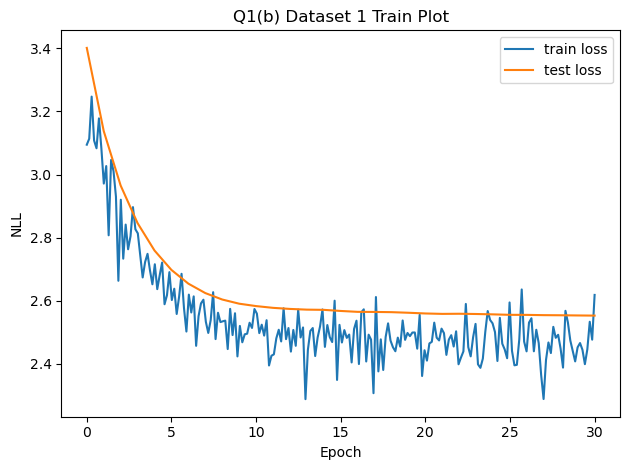

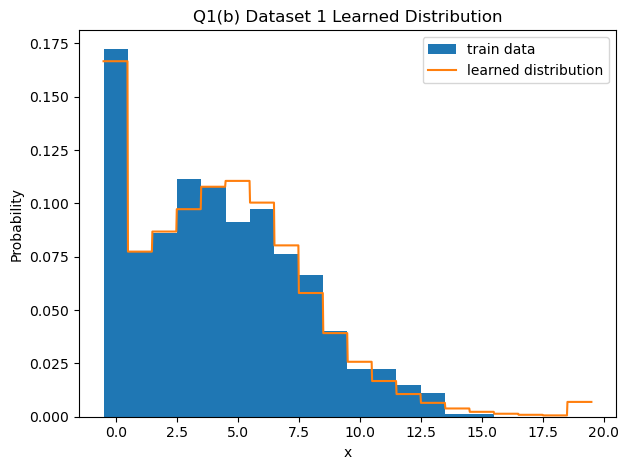

In [11]:
q1_save_results(1, 'b', q1_b)
with torch.no_grad():
    torch.cuda.empty_cache()

Parameter count: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.02it/s]

Final Test Loss: 3.7131


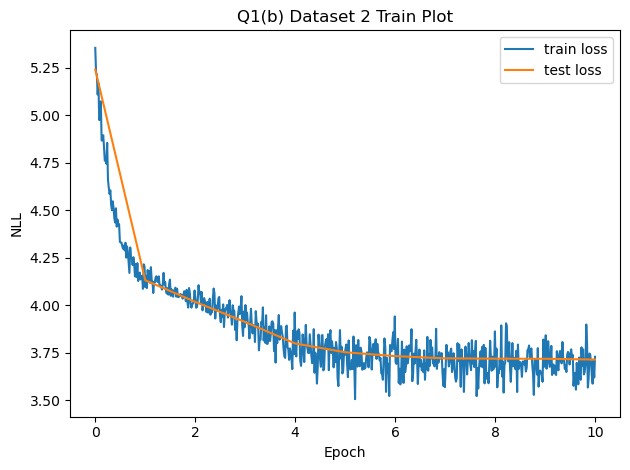

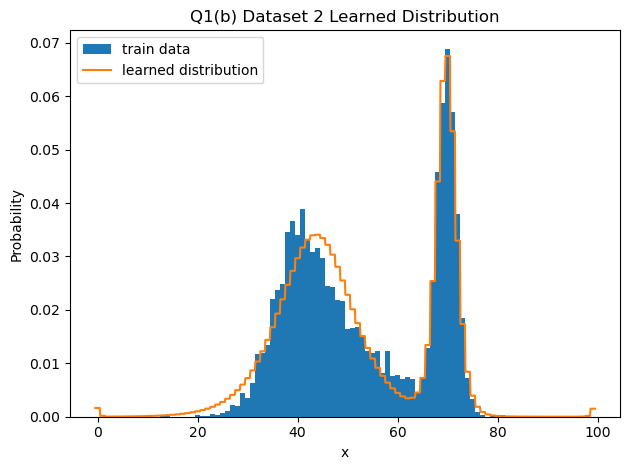

In [12]:
q1_save_results(2, 'b', q1_b)
with torch.no_grad():
    torch.cuda.empty_cache()

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN models on the shapes dataset and MNIST. In addition, we will extend to modeling colored datasets.

Run the cell below to visualize the two datasets binary datasets

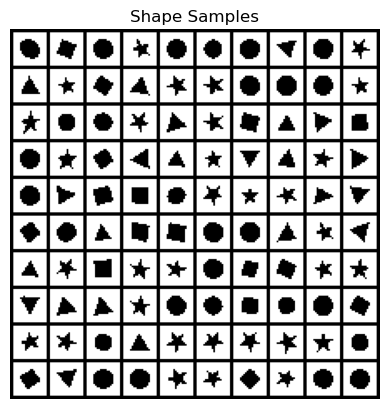

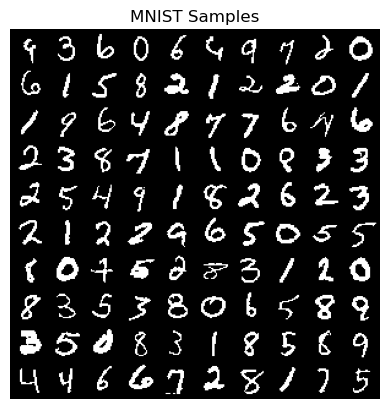

In [13]:
visualize_q2a_data(1)
visualize_q2a_data(2)

In [14]:
train_data, test_data = utils.load_pickled_data("data/shapes.pkl")
print(train_data.dtype)
print(train_data.shape)
print(test_data.shape)
print(train_data[0].squeeze())

uint8
(10479, 20, 20, 1)
(4491, 20, 20, 1)
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [15]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type: str, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert mask_type in {"A", "B"}
        self.register_buffer("mask", self.weight.data.clone())
        _, _, h, w = self.weight.size()
        self.mask.fill_(0.)
        self.mask[:, :, h // 2, :w // 2 + (mask_type == "B")] = 1.
        self.mask[:, :, :h // 2, :] = 1.
        self._mask_weight()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._mask_weight()
        return super().forward(x)

    def _mask_weight(self):
        self.weight.data.mul_(self.mask)

Let's verify the masked convolution implementation is correct.

In [16]:
conv_a = MaskedConv2d("A", 1, 1, 7, padding=(7-1) // 2)
conv_b = MaskedConv2d("B", 1, 1, 7, padding=(7-1) // 2)

print("Mask A")
print(conv_a.mask.squeeze())
print(conv_a.weight.data.squeeze())

print()
print("===========")
print()

print("Mask B")
print(conv_b.mask.squeeze())
print(conv_b.weight.data.squeeze())

Mask A
tensor([[1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])
tensor([[-0.0634, -0.0052,  0.0914,  0.1420,  0.0567,  0.0193,  0.0958],
        [-0.0841,  0.0266, -0.1108, -0.0990, -0.0738,  0.0646,  0.0575],
        [-0.0846,  0.0432,  0.0784, -0.0180,  0.0055,  0.0331,  0.0886],
        [ 0.1372, -0.1101, -0.0524,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000]])


Mask B
tensor([[1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0.

In [17]:
class BinaryPixelCNN(pytorch_util.MyModule):    
    def __init__(self, n_filters: int):
        super().__init__()        
        self.convs = nn.ModuleList(
              [MaskedConv2d("A", 1,         n_filters, 7, padding=(7-1) // 2)]
            + [MaskedConv2d("B", n_filters, n_filters, 7, padding=(7-1) // 2) for _ in range(5)]
            + [MaskedConv2d("B", n_filters, n_filters, 1)]
        )
        self.conv_out = MaskedConv2d("B", n_filters, 1, 1)
        self.print_n_params()

    @property
    def device(self):
        return self.convs[0].weight.device # self.conv_a.weight.device

    def forward(self, x):
        x = 2*x.permute(0, 3, 1, 2).float() - 1
        for conv in self.convs:
            x = F.relu(conv(x))
        return self.conv_out(x).permute(0, 2, 3, 1)
        

    def sample(self, size, n_samples):
        with torch.no_grad():
            samples = torch.zeros(n_samples, *size, 1, device=self.device, dtype=torch.uint8)
            for i in range(size[0]):
                for j in range(size[1]):
                    logits = self(samples)[:, i, j, 0]
                    sampled_pixels = torch.bernoulli(torch.sigmoid(logits)).type(torch.uint8)
                    samples[:, i, j, 0] = sampled_pixels
        return samples.cpu().numpy()

In [18]:
def q2_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  pytorch_util.set_gpu_mode("cuda", GPU_ID)
  device = pytorch_util.device
  pytorch_util.seed_rng(0)
    
  train_data = torch.from_numpy(train_data).to(device)
  test_data = torch.from_numpy(test_data).to(device)
  train_losses, test_losses = [], []

  model = BinaryPixelCNN(64)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

  def evaluate():
    with torch.no_grad():
      logits = model(test_data)
      loss = F.binary_cross_entropy_with_logits(logits, test_data.float())
      return loss.cpu().item()

  test_losses.append(evaluate())
  epochs = 15 if dset_id == 1 else 5
  for _ in tqdm(range(epochs)):
    # train loss
    for train_mbatch in train_dataloader:
      train_mbatch = train_mbatch.to(device)
      optimizer.zero_grad()
      logits = model(train_mbatch)
      loss = F.binary_cross_entropy_with_logits(logits, train_mbatch.float())
      loss.backward()
      optimizer.step()
      train_losses.append(loss.cpu().item())

    # test loss
    test_losses.append(evaluate())

  return train_losses, test_losses, model.sample(image_shape, 100)

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Parameter count: 1.01e+06


  0%|                                                                                                                                                                  | 0/15 [00:00<?, ?it/s]/home/nolan/miniforge3/envs/deepul/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/nolan/miniforge3/envs/deepul/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Va

Final Test Loss: 0.0429


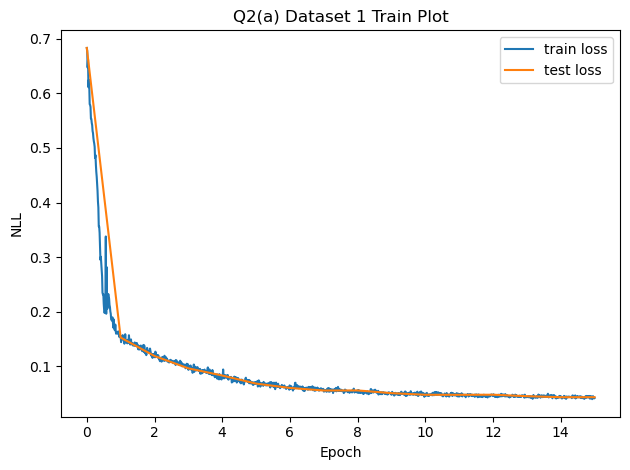

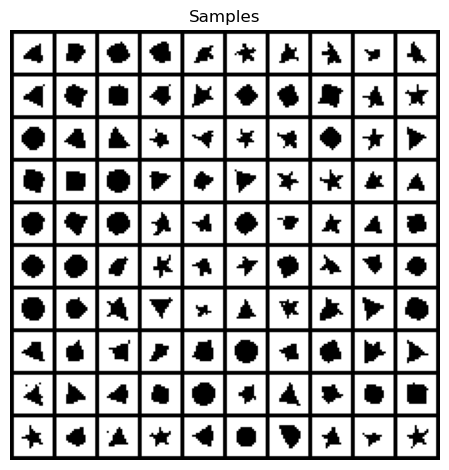

In [19]:
q2a_save_results(1, q2_a)
with torch.no_grad():
    torch.cuda.empty_cache()

Parameter count: 1.01e+06


/home/nolan/miniforge3/envs/deepul/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 14.13 GiB. GPU  has a total capacity of 11.90 GiB of which 7.89 GiB is free. Including non-PyTorch memory, this process has 4.00 GiB memory in use. Of the allocated memory 3.80 GiB is allocated by PyTorch, and 21.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Exception raised from malloc at /opt/conda/conda-bld/pytorch_1712608853085/work/c10/cuda/CUDACachingAllocator.cpp:1143 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7f4268f78897 in /home/nolan/miniforge3/envs/deepul/lib/python3.11/site-packages/torch/lib/libc10

Final Test Loss: 0.0805


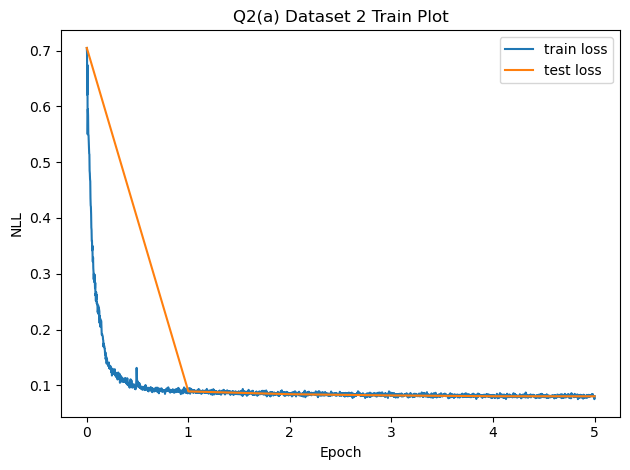

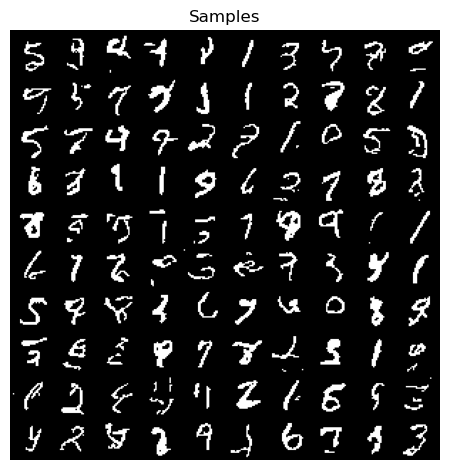

In [20]:
q2a_save_results(2, q2_a)
with torch.no_grad():
    torch.cuda.empty_cache()

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

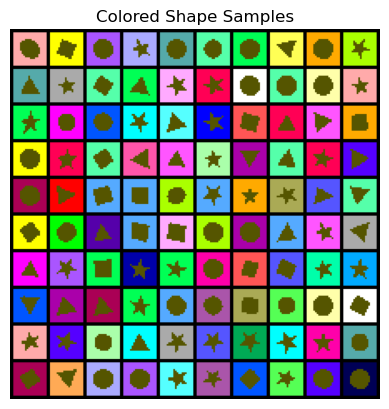

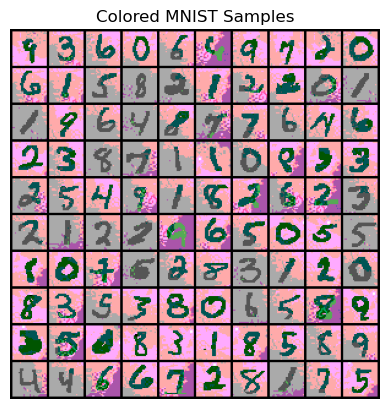

In [21]:
visualize_q2b_data(1)
visualize_q2b_data(2)

In [22]:
train_data, test_data = utils.load_pickled_data("data/shapes_colored.pkl")
print(train_data.dtype)
print(train_data.shape)
print(test_data.shape)
train_data_one_hot = F.one_hot(torch.from_numpy(train_data).long(), num_classes=4)
print(train_data_one_hot.shape)

print(train_data[0, :2, :3].squeeze())
print("=======")
print(train_data_one_hot[0, :2, :3])

uint8
(10479, 20, 20, 3)
(4491, 20, 20, 3)
torch.Size([10479, 20, 20, 3, 4])
[[[1 0 2]
  [1 0 2]
  [1 0 2]]

 [[1 0 2]
  [1 0 2]
  [1 0 2]]]
tensor([[[[0, 1, 0, 0],
          [1, 0, 0, 0],
          [0, 0, 1, 0]],

         [[0, 1, 0, 0],
          [1, 0, 0, 0],
          [0, 0, 1, 0]],

         [[0, 1, 0, 0],
          [1, 0, 0, 0],
          [0, 0, 1, 0]]],


        [[[0, 1, 0, 0],
          [1, 0, 0, 0],
          [0, 0, 1, 0]],

         [[0, 1, 0, 0],
          [1, 0, 0, 0],
          [0, 0, 1, 0]],

         [[0, 1, 0, 0],
          [1, 0, 0, 0],
          [0, 0, 1, 0]]]])


Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [23]:
class BaseColorPixelCNN(pytorch_util.MyModule):
    def __init__(self):
        super().__init__()
        self.n_colors = 4
        self.n_channels = 3

    def sample(self, size: Tuple[int, int, int], n_samples: int) -> np.ndarray:
        """
        size: tuple corresponding to (H, W, C)
        n_samples: number of samples

        Returns
        - a numpy array of size (n_samples, H, W, C) of samples with values in {0, 1, 2, 3}
        """
        with torch.no_grad():
            samples = torch.zeros(n_samples, *size, device=self.device, dtype=torch.uint8)
            for i in range(size[0]):
                for j in range(size[1]):
                    logits = self(samples)[:, i, j] # (n_samples, C, colors)
                    probs = F.softmax(logits, -1) # (n_samples, C, colors)
                    probs_flat = probs.view(-1, self.n_colors) # (n_samples * C, colors)
                    sampled_pixels_flat = torch.multinomial(probs_flat, num_samples=1) # (n_samples * C, 1)
                    sampled_pixels = sampled_pixels_flat.view(logits.shape[:2]) # (n_samples, C)
                    samples[:, i, j] = sampled_pixels
        return samples.cpu().numpy()

First, we implement a residual block, which alternates between layer normalization (optional), ReLU non-linearity, and masked type B convolution.

To maintain the autoregressive property, we compute the layer normalization over the *channels* of the feature $x_{b,i,j,c}$, i.e., the mean and variance are computed as:
\begin{align*}
\mu_{b,i,j} &= \mathbb{E}_{c, (i', j') \in W(i, j)} [x_{b,i',j',c}] \\
\sigma_{b,i,j}^2 &= \mathrm{var}_{c, (i',j') \in W(i,j)} (x_{b,i',j',c})
\end{align*}

In [24]:
class AutoregressiveLayerNorm(nn.Module):
    def __init__(self, channels: int, kernel_size: int = 7):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(channels))
        self.bias = nn.Parameter(torch.zeros(channels))
        self.register_buffer("mean_filter", torch.zeros(1, channels, kernel_size, kernel_size))
        self.mean_filter[:, :, kernel_size // 2, :kernel_size // 2 + 1] = 1.
        self.mean_filter[:, :, :kernel_size // 2, :] = 1.
        self.mean_filter /= self.mean_filter.sum()
        self.kernel_size = kernel_size

    def forward(self, x: torch.Tensor):
        """
        x: a (batch, channels, H, W) float tensor

        Returns
        - a (batch, channels, H, W) float tensor
        """
        means = F.conv2d(x, self.mean_filter, padding=(self.kernel_size-1) // 2)  # (batch, 1, h, w)

        deltas = x - means # (batch, channels, H, W)
        sq_deltas = torch.square(x - means) # (batch, channels, H,  W)
        vars = F.conv2d(sq_deltas, self.mean_filter, padding=(self.kernel_size-1) // 2)  # (batch, 1, H, W)

        x_whitened = deltas / torch.sqrt(vars + 1e-5)  # (batch, channels, H, W)

        return self.weight[:, None, None] * x_whitened + self.bias[:, None, None]

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, n_filters: int, layer_norm: bool = True):
        super().__init__()

        self.convs = nn.ModuleList([
            MaskedConv2d("B", n_filters, n_filters, 1),
            MaskedConv2d("B", n_filters, n_filters, 7, padding=(7-1) // 2),
            MaskedConv2d("B", n_filters, n_filters, 1)
        ])

        #layer_norm_ctor = nn.LayerNorm if layer_norm else nn.Identity
        layer_norm_ctor = AutoregressiveLayerNorm if layer_norm else nn.Identity
        self.lns = nn.ModuleList([layer_norm_ctor(n_filters) for _ in range(3)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: a (batch, n_filters, H, W) float tensor

        Returns
        - a (batch, n_filters, H, W) float tensor
        """
        y = x

        for conv, ln in zip(self.convs, self.lns):
            #y = ln(y.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
            y = ln(y)
            y = F.relu(y)
            y = conv(y)

        return x + y

We first implement a `FullySeparatedColorPixelCNN` which applies which applies 3 `ChannelPixelCNN`'s to the image, one per channel.

In [26]:
class ChannelPixelCNN(nn.Module):
    def __init__(self, n_filters: int, layer_norm: bool = True):
        super().__init__()
        self.n_channels = 3
        self.n_colors = 4
        self.conv_a = MaskedConv2d("A", self.n_channels, n_filters, 7, padding=(7-1) // 2)
        self.resids = nn.ModuleList([ResidualBlock(n_filters, layer_norm) for _ in range(8)])
        self.conv_proj = MaskedConv2d("B", n_filters, self.n_colors, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: a (batch, H, W, C) uint8 tensor of color images with values in {0, 1, 2, 3}

        Returns
        - a tensor of logits with shape (batch, H, W, 4)
        """
        x = 2/3*x.permute(0, 3, 1, 2).float() - 1 # (batch, C, H, W)
        x = self.conv_a(x)
        for resid in self.resids:
            x = resid(x)
        return self.conv_proj(x).permute(0, 2, 3, 1)


class FullySeparatedColorPixelCNN(BaseColorPixelCNN):
    def __init__(self, n_filters: int, layer_norm: bool = True):
        super().__init__()
        self.cnns = nn.ModuleList([ChannelPixelCNN(n_filters, layer_norm) for _ in range(self.n_channels)])
        self.print_n_params()

    @property
    def device(self):
        return self.cnns[0].conv_a.weight.device

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: A (batch, H, W, C) uint8 tensor of color images with values in {0, 1, 2, 3}

        Returns
        - a tensor of logits with shape (batch, H, W, C, 4)
        """
        logits = torch.empty(*x.shape, self.n_colors, device=x.device) # (batch, H, W, C, colors)
        for i, cnn in enumerate(self.cnns):
            logits[:, :, :, i] = cnn(x)
        return logits

We also implement a `MultiTailedColorPixelCNN`, which applies 3 separate modules consisting of masked type A convolution and two residual blocks. The outputted features are then concatenated along the batch dimension and then processed through six residual blocks to form the logits.

In [27]:
class MultiTailedColorPixelCNN(BaseColorPixelCNN):
    def __init__(self, n_filters: int, layer_norm: bool = True):
        super().__init__()
        self.convs_a = nn.ModuleList([MaskedConv2d("A", self.n_channels, n_filters, 7, padding=(7-1) // 2) for _ in range(self.n_channels)])
        self.resids_separate = nn.ModuleList([
            nn.ModuleList([ResidualBlock(n_filters, layer_norm) for _ in range(2)])
        for _ in range(self.n_channels)])
        self.resids_shared = nn.ModuleList([ResidualBlock(n_filters, layer_norm) for _ in range(6)])
        self.conv_out = MaskedConv2d("B", n_filters, self.n_colors, 1)
        self.print_n_params()

    @property
    def device(self):
        return self.conv_out.weight.device
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: a (batch, H, W, C) uint8 tensor of color images with values in {0, 1, 2, 3}

        Returns
        - a tensor of logits with shape (batch, H, W, C, 4)
        """
        x = 2/3*x.permute(0, 3, 1, 2).float() - 1. # (batch, C, H, W)

        xs = []
        for conv_a, resids in zip(self.convs_a, self.resids_separate):
            y = x
            y = conv_a(y)
            for resid in resids:
                y = resid(y)
            xs.append(y)

        x = torch.cat(xs, dim=0) # (C * batch, n_filters, H, W)
        for resid in self.resids_shared:
            x = resid(x)
        x = self.conv_out(x) # (C * batch, colors, H, W)
        x = x.view(self.n_channels, -1, self.n_colors, x.shape[-2], x.shape[-1]) # (C, batch, colors, H, W)
        x = x.permute(1, 3, 4, 0, 2) # (batch, H, W, C, 4)

        return x

Finally, we implement a `MultiHeadedColorPixelCNN`, which first applies six layers of residual blocks to the image. Then, the outputted features are fed through 3 separate modules (one per channel) of two residual blocks to form the logits.

In [28]:
class MultiHeadedColorPixelCNN(BaseColorPixelCNN):
    def __init__(self, n_filters: int, layer_norm: bool = True):
        super().__init__()
        self.conv_a = MaskedConv2d("A", self.n_channels, n_filters, 7, padding=(7-1) // 2)
        self.resids_shared = nn.ModuleList([ResidualBlock(n_filters, layer_norm) for _ in range(6)])
        self.resids_separate = nn.ModuleList([
            nn.ModuleList([ResidualBlock(n_filters, layer_norm) for _ in range(2)])
            for _ in range(self.n_channels)])
        self.convs_out = nn.ModuleList([MaskedConv2d("B", n_filters, self.n_colors, 1) for _ in range(self.n_channels)])
        self.print_n_params()

    @property
    def device(self):
        return self.conv_a.weight.device
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: a (batch, H, W, C) uint8 tensor of color images with values in {0, 1, 2, 3}

        Returns
        - a tensor of logits with shape (batch, H, W, C, 4)
        """
        x = 2/3*x.permute(0, 3, 1, 2).float() - 1 # (batch, C, H, W)
        
        x = self.conv_a(x)
        for resid in self.resids_shared:
            x = resid(x)

        xs = []
        for resids, conv in zip(self.resids_separate, self.convs_out):
            y = x
            for resid in resids:
                y = resid(y)
            y = conv(y)
            xs.append(y)

        x = torch.stack(xs, dim=-1) # (batch, colors, H, W, C)
        x = x.permute(0, 2, 3, 4, 1) # (batch, H, W, C, colors)

        return x

In [29]:
make_pixel_cnn = lambda: None # placeholder

def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  pytorch_util.set_gpu_mode("cuda", GPU_ID)
  device = pytorch_util.device
  pytorch_util.seed_rng(0)
    
  train_data = torch.from_numpy(train_data)
  test_data = torch.from_numpy(test_data)
  train_losses, test_losses = [], []

  model = make_pixel_cnn()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
  test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False)

  def evaluate():
    losses = []
    with torch.no_grad():
      for test_mbatch in test_dataloader:
        test_mbatch = test_mbatch.to(device)
        logits = model(test_mbatch)
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), test_mbatch.ravel())
        losses.append(loss.cpu().item())
    return np.mean(losses)

  test_losses.append(evaluate())
  epochs = 8 if dset_id == 1 else 3
  for _ in tqdm(range(epochs)):
    # train loss
    for train_mbatch in train_dataloader:
      train_mbatch = train_mbatch.to(device)
      optimizer.zero_grad()
      logits = model(train_mbatch)
      loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), train_mbatch.ravel())
      loss.backward()
      optimizer.step()

      train_losses.append(loss.cpu().item())

    # test loss
    test_losses.append(evaluate())

  return train_losses, test_losses, model.sample(image_shape, 100)

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



#### Fully separated PixelCNN's

First, we try without layer norm.

In [30]:
make_pixel_cnn = lambda: FullySeparatedColorPixelCNN(90, False)

Fully separated, no layer norm
Parameter count: 9.96e+06


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:10<00:00, 46.30s/it]


Final Test Loss: 0.0518


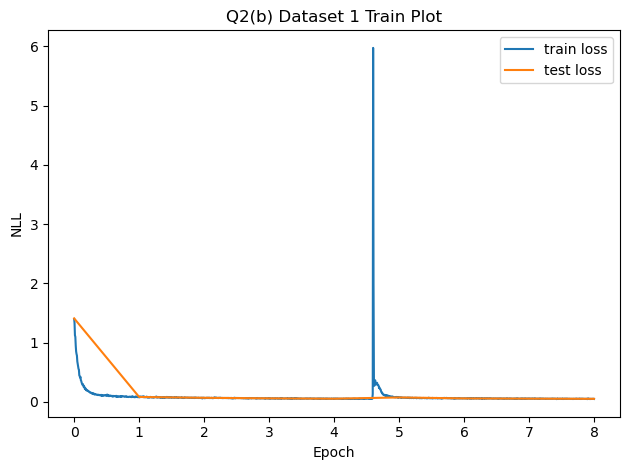

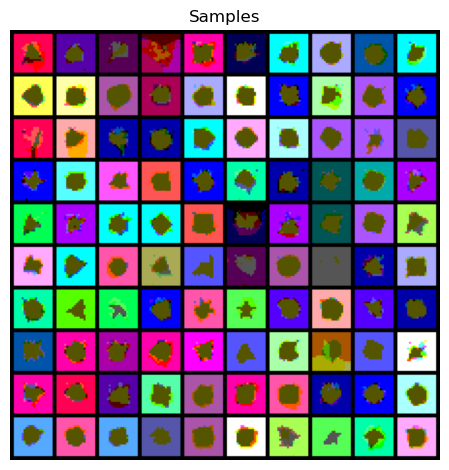

In [31]:
print("Fully separated, no layer norm")
q2b_save_results(1, 'b', q2_b)
with torch.no_grad():
    torch.cuda.empty_cache()

Fully separated, no layer norm
Parameter count: 9.96e+06


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [27:50<00:00, 556.85s/it]


Final Test Loss: 0.0871


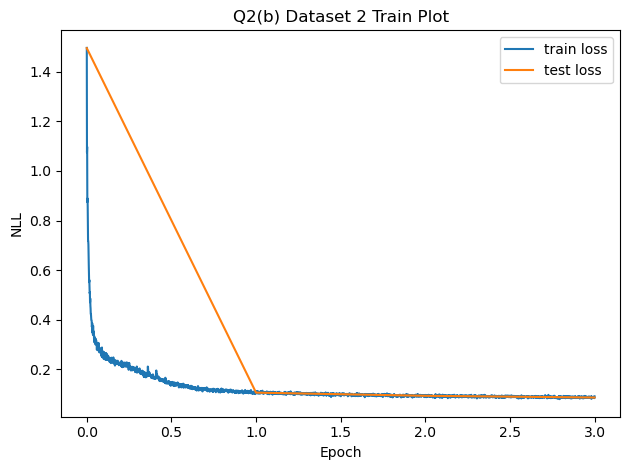

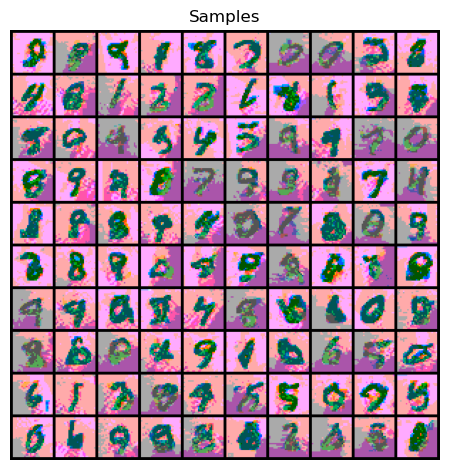

In [32]:
print("Fully separated, no layer norm")
q2b_save_results(2, 'b', q2_b)
with torch.no_grad():
    torch.cuda.empty_cache()

Now, we try with layer norm.

In [33]:
make_pixel_cnn = lambda: FullySeparatedColorPixelCNN(90, True)

Fully separated, layer norm
Parameter count: 9.97e+06


/tmp/ipykernel_1122761/3795308977.py:19: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  means = F.conv2d(x, self.mean_filter, padding=(self.kernel_size-1) // 2)  # (batch, 1, h, w)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [11:12<00:00, 84.07s/it]


Final Test Loss: 0.0466


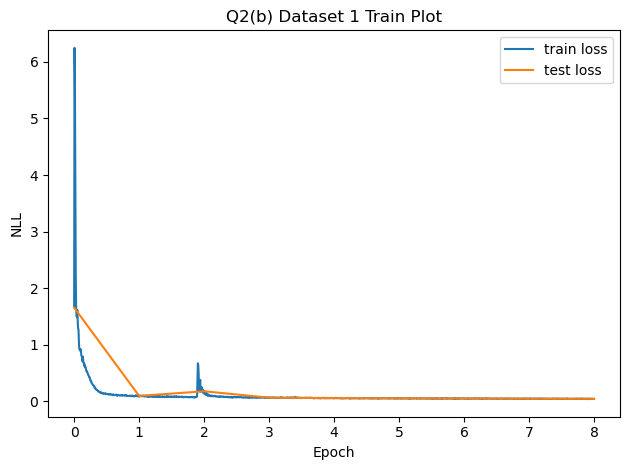

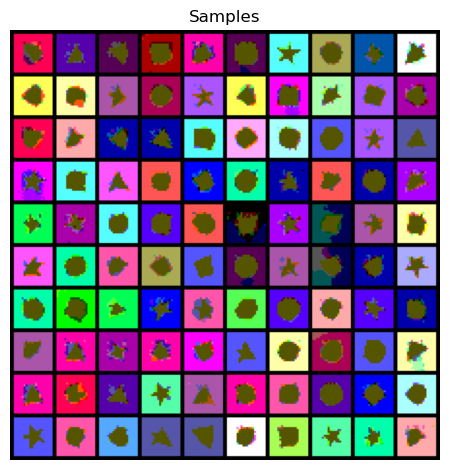

In [34]:
print("Fully separated, layer norm")
q2b_save_results(1, 'b', q2_b)
with torch.no_grad():
    torch.cuda.empty_cache()

Fully separated, layer norm
Parameter count: 9.97e+06


/tmp/ipykernel_1122761/3795308977.py:19: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  means = F.conv2d(x, self.mean_filter, padding=(self.kernel_size-1) // 2)  # (batch, 1, h, w)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [53:27<00:00, 1069.22s/it]


Final Test Loss: 0.1882


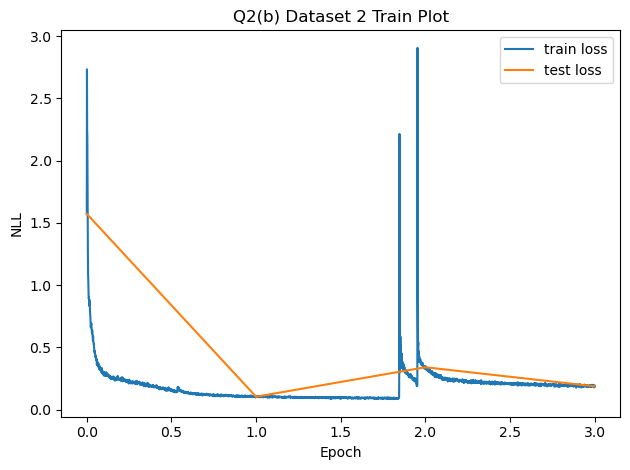

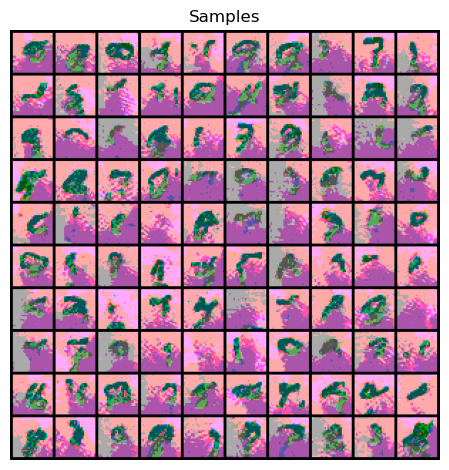

In [35]:
print("Fully separated, layer norm")
q2b_save_results(2, 'b', q2_b)
with torch.no_grad():
    torch.cuda.empty_cache()

#### Multi-tailed PixelCNN's

First, we try without layer norm.

In [36]:
make_pixel_cnn = lambda: MultiTailedColorPixelCNN(128, False)

Multi-tailed, no layer norm
Parameter count: 1.01e+07


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [07:07<00:00, 53.49s/it]


Final Test Loss: 0.0548


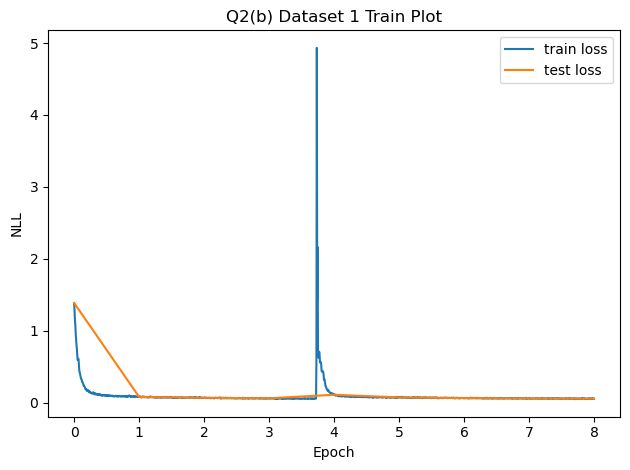

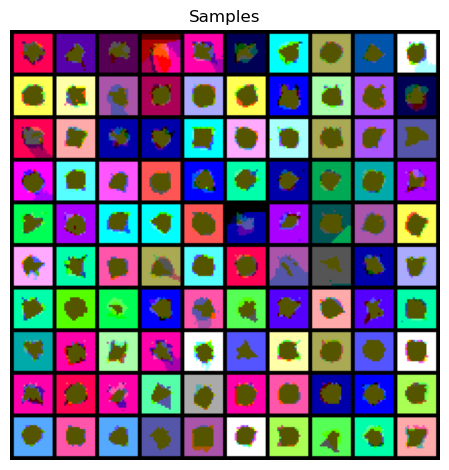

In [37]:
print("Multi-tailed, no layer norm")
q2b_save_results(1, 'b', q2_b)
with torch.no_grad():
    torch.cuda.empty_cache()

Multi-tailed, no layer norm
Parameter count: 1.01e+07


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [31:42<00:00, 634.12s/it]


Final Test Loss: 0.1009


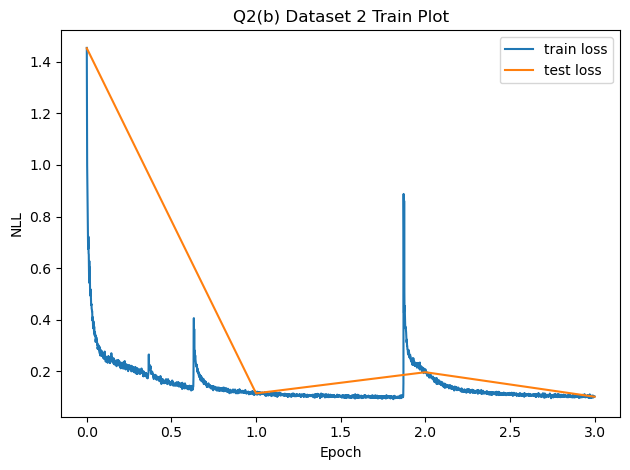

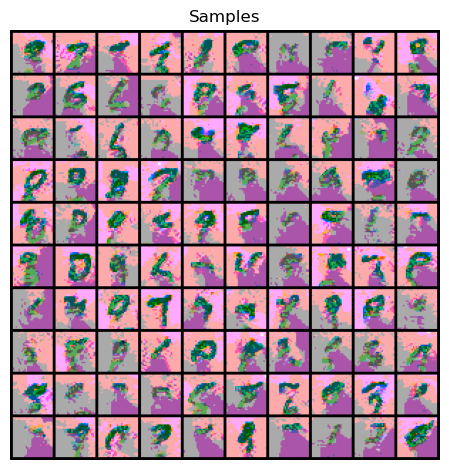

In [38]:
print("Multi-tailed, no layer norm")
q2b_save_results(2, 'b', q2_b)
with torch.no_grad():
    torch.cuda.empty_cache()

Now, we try with layer norm.

In [39]:
make_pixel_cnn = lambda: MultiTailedColorPixelCNN(128, True)

Multi-tailed, layer norm
Parameter count: 1.01e+07


/tmp/ipykernel_1122761/3795308977.py:19: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  means = F.conv2d(x, self.mean_filter, padding=(self.kernel_size-1) // 2)  # (batch, 1, h, w)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [13:09<00:00, 98.73s/it]


Final Test Loss: 0.0590


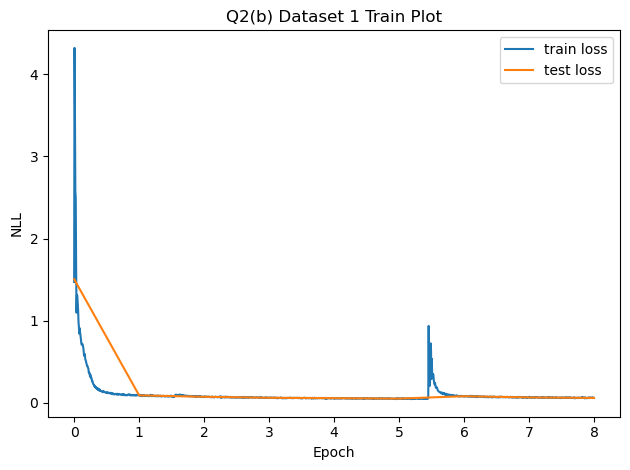

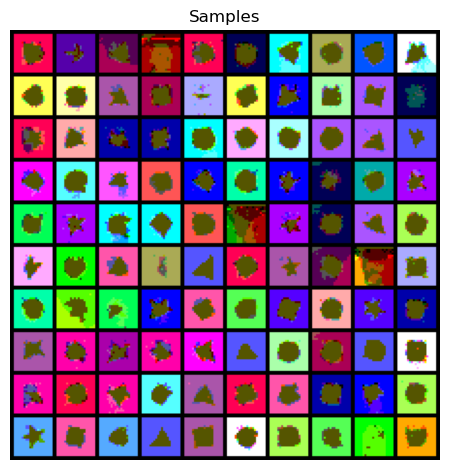

In [40]:
print("Multi-tailed, layer norm")
q2b_save_results(1, 'b', q2_b)
with torch.no_grad():
    torch.cuda.empty_cache()

In [41]:
print("Multi-tailed, layer norm")
#q2b_save_results(2, 'b', q2_b)
#with torch.no_grad():
#    torch.cuda.empty_cache()
print("Fails to run due to insufficient VRAM")

Multi-tailed, layer norm
Fails to run due to insufficient VRAM


#### Multi-headed PixelCNN's

First, we try without layer norm.

In [42]:
make_pixel_cnn = lambda: MultiHeadedColorPixelCNN(128, False)

Multi-headed, no layer norm
Parameter count: 1.01e+07


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:49<00:00, 28.74s/it]


Final Test Loss: 0.0494


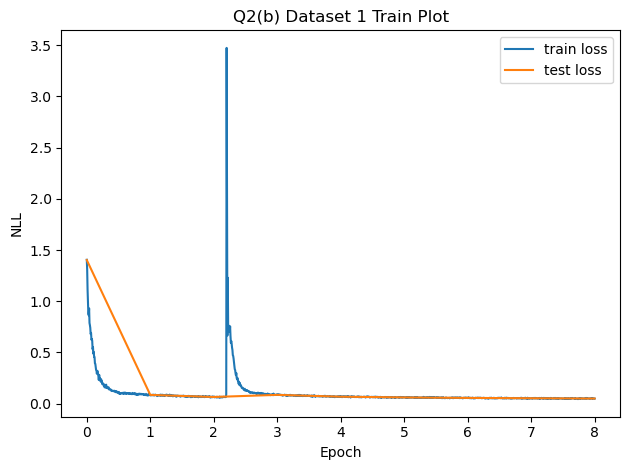

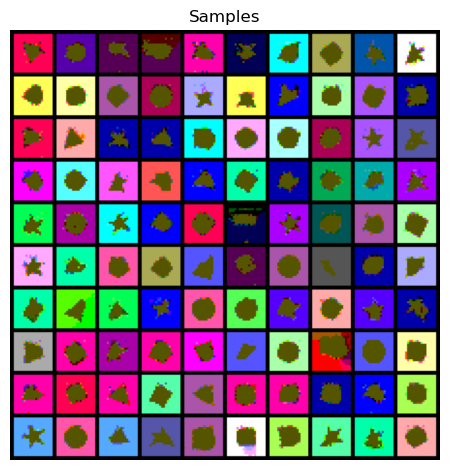

In [43]:
print("Multi-headed, no layer norm")
q2b_save_results(1, 'b', q2_b)
with torch.no_grad():
    torch.cuda.empty_cache()

Multi-headed, no layer norm
Parameter count: 1.01e+07


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [16:20<00:00, 326.75s/it]


Final Test Loss: 0.0951


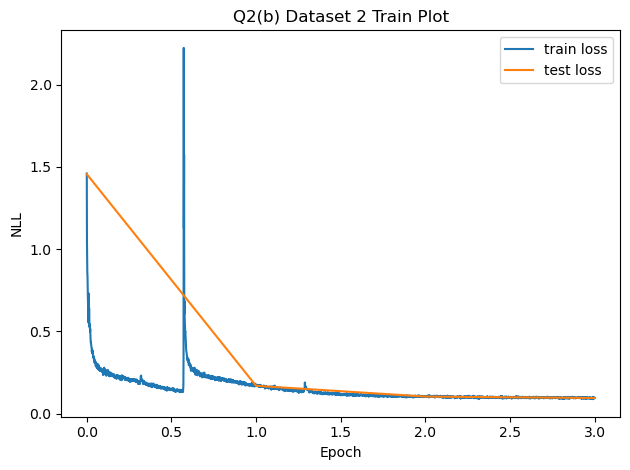

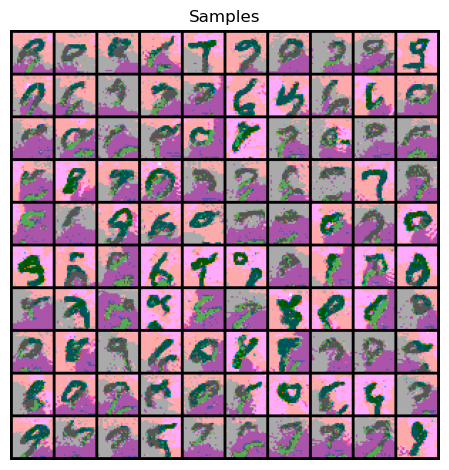

In [44]:
print("Multi-headed, no layer norm")
q2b_save_results(2, 'b', q2_b)
with torch.no_grad():
    torch.cuda.empty_cache()

Now, we try with layer norm.

In [45]:
make_pixel_cnn = lambda: MultiHeadedColorPixelCNN(128, True)

Multi-headed, layer norm
Parameter count: 1.01e+07


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:47<00:00, 50.88s/it]


Final Test Loss: 0.0459


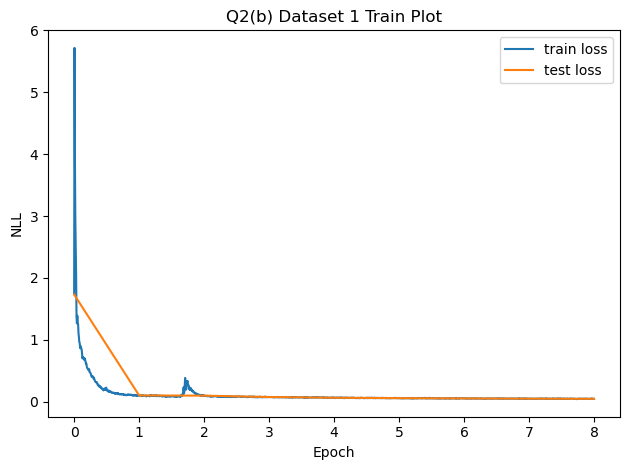

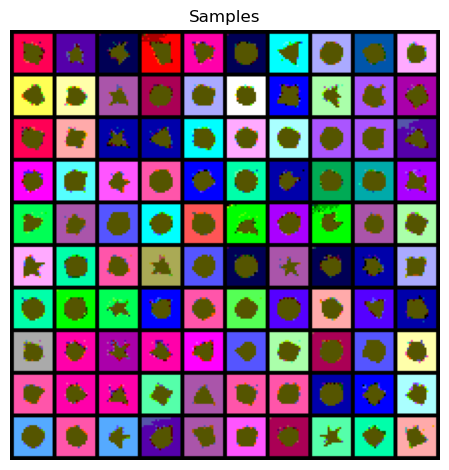

In [46]:
print("Multi-headed, layer norm")
q2b_save_results(1, 'b', q2_b)
with torch.no_grad():
    torch.cuda.empty_cache()

Multi-headed, layer norm
Parameter count: 1.01e+07


/tmp/ipykernel_1122761/3795308977.py:19: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  means = F.conv2d(x, self.mean_filter, padding=(self.kernel_size-1) // 2)  # (batch, 1, h, w)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [30:27<00:00, 609.09s/it]


Final Test Loss: 0.0863


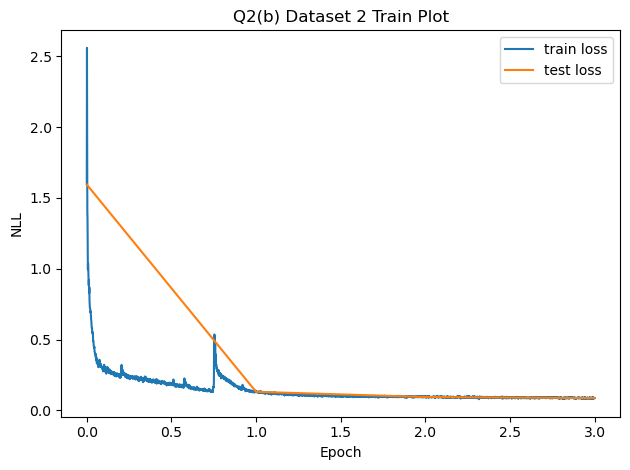

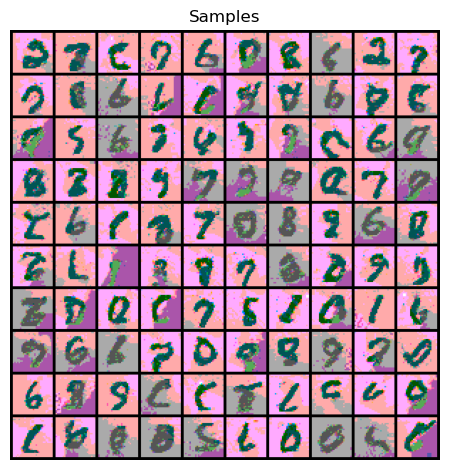

In [47]:
print("Multi-headed, layer norm")
q2b_save_results(2, 'b', q2_b)
with torch.no_grad():
    torch.cuda.empty_cache()

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer). 

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. PyTorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cosine learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



Let's build the causal self-attention layer bit by bit, first. We start by defining some hyperparameters and an arbitrary input $X \in \mathbb{R}^{L \times dh}$, where $L$ is the sequence length, $d$ is the embedding dimension, and $h$ is the number of attention heads.

In [48]:
batch = 2
seq_length = 3
num_heads = 4
embed_dim = 5
x = torch.randn(batch, seq_length, embed_dim * num_heads)
print("X shape:", x.shape)
print("X")
print(x.data)

X shape: torch.Size([2, 3, 20])
X
tensor([[[ 0.8773, -0.9644, -0.8707,  2.4386, -1.0718,  0.5305,  0.7494,
          -0.2619,  1.1808, -0.0784,  0.0316,  2.2203,  0.1381, -0.4796,
           0.1410,  0.2137,  2.8708,  0.0175,  0.4788,  1.0667],
         [-0.7426,  0.2111,  0.3039, -1.6356,  0.2660, -0.2033, -0.8725,
           1.3195, -0.5525,  0.1757, -0.8185,  1.9889, -0.8362,  0.3275,
          -0.6032, -0.2194,  0.1595,  0.0079,  0.1464, -0.1947],
         [ 1.4212,  0.2625,  0.6627,  1.1097, -0.4135,  0.4929, -2.3948,
          -1.3670, -1.1400, -0.0154,  0.8463, -0.4029,  0.0709, -0.0657,
          -1.0405,  0.4073, -0.4098, -0.3982,  0.9348,  0.1747]],

        [[-0.4633, -0.3308,  0.1198,  0.7018,  0.8821, -0.9694,  0.7148,
          -0.7687,  0.2997,  0.4966, -0.9034, -1.3689, -1.4485, -0.3343,
          -1.0580, -0.8058,  2.2568, -0.2611, -0.6885,  0.2388],
         [-0.6207,  1.5996, -0.0625,  0.3297,  1.2597,  1.7415,  1.2933,
           0.0805,  0.7611,  1.4395, -1.2492, -

We then build a layer that maps $X$ to $Q$, $K$, and $V$, each of which is an $L \times d$ matrix. Namely, we rely on the linear property to efficiently compute them:
$$
\begin{bmatrix} Q \\ K \\ V \end{bmatrix} = \begin{bmatrix} W_Q \\ W_K \\ W_V \end{bmatrix} X,
$$
where each weight matrix is $L \times L$.

In [49]:
qkv_layer = nn.Linear(embed_dim*num_heads, 3*embed_dim*num_heads, bias=False)
qkv = qkv_layer(x)
print("QKV shape:", list(qkv.size()))  # (batch, seq_length, 3*embed_dim*num_heads)

q, k, v = torch.split(qkv, embed_dim*num_heads, dim=2)  # (batch, seq_length, embed_dim*num_heads)
print("V shape:", list(v.size()))
print("V:")
print(v.data)

QKV shape: [2, 3, 60]
V shape: [2, 3, 20]
V:
tensor([[[ 1.2246, -0.7482,  0.8298,  0.8868,  0.3516,  1.1452, -0.4518,
          -0.9063,  1.3998,  0.7222, -0.6567, -0.1819,  0.4964,  0.3342,
          -0.2579,  1.2748, -0.6289, -0.1687, -0.8569, -0.3365],
         [-0.5235,  0.0339,  0.4591,  0.6077, -0.4148, -0.1875,  0.2877,
           0.9999,  0.2982,  0.0127, -0.0046,  0.1121,  0.4348,  0.5974,
          -0.4343,  0.4048, -0.0687,  0.6635,  0.0569, -0.6693],
         [-0.3557, -0.3925, -1.1170,  0.7497,  0.6896,  0.4429, -1.2006,
          -0.4988, -0.4713,  0.8827,  0.5733,  0.5412, -0.1098, -0.0751,
           0.1376,  0.1504, -0.2080, -0.7859,  0.1418,  0.1093]],

        [[ 1.0901, -0.1445,  0.8350,  0.1523,  0.7763,  0.4137,  1.4765,
          -0.3208,  0.0405,  0.7809,  0.8755, -0.5335, -0.6308,  0.4216,
          -0.2084, -0.6893, -0.5151, -0.4668,  0.2891, -0.1103],
         [-0.1360, -0.2245,  0.4604, -0.5112,  0.0353,  0.1018,  0.0205,
          -1.0797, -0.2709, -0.8643,

Since we're doing multi-head attention, we evenly partition $Q$, $K$, and $V$ between the different attention heads. The forthcoming math parallelizes over the heads.

In [50]:
# q, k, v each of shape (batch, num_heads, seq_length, embed_dim)
q = q.view(batch, seq_length, num_heads, embed_dim).permute(0, 2, 1, 3)
k = k.view(batch, seq_length, num_heads, embed_dim).permute(0, 2, 1, 3)
v = v.view(batch, seq_length, num_heads, embed_dim).permute(0, 2, 1, 3)

print("V shape:", list(v.size()))
print("V:")
print(v.data)

V shape: [2, 4, 3, 5]
V:
tensor([[[[ 1.2246, -0.7482,  0.8298,  0.8868,  0.3516],
          [-0.5235,  0.0339,  0.4591,  0.6077, -0.4148],
          [-0.3557, -0.3925, -1.1170,  0.7497,  0.6896]],

         [[ 1.1452, -0.4518, -0.9063,  1.3998,  0.7222],
          [-0.1875,  0.2877,  0.9999,  0.2982,  0.0127],
          [ 0.4429, -1.2006, -0.4988, -0.4713,  0.8827]],

         [[-0.6567, -0.1819,  0.4964,  0.3342, -0.2579],
          [-0.0046,  0.1121,  0.4348,  0.5974, -0.4343],
          [ 0.5733,  0.5412, -0.1098, -0.0751,  0.1376]],

         [[ 1.2748, -0.6289, -0.1687, -0.8569, -0.3365],
          [ 0.4048, -0.0687,  0.6635,  0.0569, -0.6693],
          [ 0.1504, -0.2080, -0.7859,  0.1418,  0.1093]]],


        [[[ 1.0901, -0.1445,  0.8350,  0.1523,  0.7763],
          [-0.1360, -0.2245,  0.4604, -0.5112,  0.0353],
          [-0.4236,  1.2614, -0.2510,  0.5778,  0.5912]],

         [[ 0.4137,  1.4765, -0.3208,  0.0405,  0.7809],
          [ 0.1018,  0.0205, -1.0797, -0.2709, -0.8

Now, we compute the dot product score:
$$
\frac{QK^T}{\sqrt d},
$$
which is an $L \times L$ matrix.

In particular, note that the matrix has the form:
\begin{align*}
QK^T
&= \begin{bmatrix} q_1^T \\ \vdots \\ q_L^T \end{bmatrix} \begin{bmatrix} k_1 & \cdots & k_L \end{bmatrix} \\
&= \begin{bmatrix}
q_1^T k_1 & \cdots & q_1^T k_L \\
\vdots & \ddots & \vdots \\
q_L^T k_1 & \cdots & q_L^T k_L
\end{bmatrix} \\
&= \begin{bmatrix} q_1^T K^T \\ \vdots \\ q_L^T K^T \end{bmatrix} .
\end{align*}
Essentially, each row $i$ of the score matrix corresponds to some query $q_i$.

In [51]:
score = torch.matmul(q, k.transpose(2, 3)) / np.sqrt(embed_dim)
print("Score shape:", list(score.size()))  # (batch, num_heads, seq_length, seq_length)
print("Score:")
print(score.data)

Score shape: [2, 4, 3, 3]
Score:
tensor([[[[-0.4716,  0.5747, -0.4921],
          [ 0.3663, -0.1528,  0.1740],
          [-0.7866,  0.0391,  0.2140]],

         [[-0.3154, -0.2060,  0.1278],
          [ 0.3855,  0.0630, -0.1438],
          [-0.4968,  0.0685,  0.3936]],

         [[ 0.2163,  0.1003, -0.1204],
          [ 0.3749,  0.1671, -0.0062],
          [-0.0841, -0.0958, -0.0445]],

         [[ 0.1919, -0.0171,  0.9794],
          [-0.4806,  0.2086, -0.7003],
          [-0.0326, -0.0229,  0.6305]]],


        [[[-0.1318, -0.0940,  0.7706],
          [-0.0490, -0.0072,  0.2121],
          [ 0.0089,  0.0161, -0.2580]],

         [[-0.3410,  0.8940, -0.6960],
          [ 0.5778, -0.3237, -0.4986],
          [-0.4139,  0.2571,  0.2059]],

         [[-0.2705, -0.0923,  0.3245],
          [ 0.3149,  0.2976,  0.6105],
          [ 0.1685, -0.6337,  0.2310]],

         [[ 0.2646, -0.0476,  0.2450],
          [-0.3488,  0.7570, -0.7345],
          [ 0.1810, -0.3128,  0.4546]]]])


To make the attention layer causal, we mask the score tensor so that the $(i, j)$-entry is $-\infty$ if $i < j$. This is accomplished using the lower-triangular matrix:
$$
\begin{bmatrix}
0 & 1 & 1 & 1 & \cdots & 1 & 1 & 1 \\
0 & 0 & 1 & 1 & \cdots & 1 & 1 & 1 \\
0 & 0 & 0 & 1 & \cdots & 1 & 1 & 1 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & 0 & 1 & 1 \\
0 & 0 & 0 & 0 & \cdots & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & \cdots & 0 & 0 & 0
\end{bmatrix}
$$

In [52]:
mask = ~(torch.tril(torch.ones(seq_length, seq_length)).bool())
print("Mask shape:", list(mask.size()))
print("Mask:")
print(mask.int())

Mask shape: [3, 3]
Mask:
tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]], dtype=torch.int32)


We now mask $QK^T / \sqrt{d}$ into $S$.

In [53]:
score.masked_fill_(mask, -torch.inf)
print("Masked score:")
print(score.data)

Masked score:
tensor([[[[-0.4716,    -inf,    -inf],
          [ 0.3663, -0.1528,    -inf],
          [-0.7866,  0.0391,  0.2140]],

         [[-0.3154,    -inf,    -inf],
          [ 0.3855,  0.0630,    -inf],
          [-0.4968,  0.0685,  0.3936]],

         [[ 0.2163,    -inf,    -inf],
          [ 0.3749,  0.1671,    -inf],
          [-0.0841, -0.0958, -0.0445]],

         [[ 0.1919,    -inf,    -inf],
          [-0.4806,  0.2086,    -inf],
          [-0.0326, -0.0229,  0.6305]]],


        [[[-0.1318,    -inf,    -inf],
          [-0.0490, -0.0072,    -inf],
          [ 0.0089,  0.0161, -0.2580]],

         [[-0.3410,    -inf,    -inf],
          [ 0.5778, -0.3237,    -inf],
          [-0.4139,  0.2571,  0.2059]],

         [[-0.2705,    -inf,    -inf],
          [ 0.3149,  0.2976,    -inf],
          [ 0.1685, -0.6337,  0.2310]],

         [[ 0.2646,    -inf,    -inf],
          [-0.3488,  0.7570,    -inf],
          [ 0.1810, -0.3128,  0.4546]]]])


We then compute the weight matrix $W$ through $W = \mathrm{softmax}(S)$, where the softmax is done over the rows.

In [54]:
weight = torch.softmax(score, dim=3)
print("Weight shape:", list(weight.size()))
print("Weight:")
print(weight.data)

Weight shape: [2, 4, 3, 3]
Weight:
tensor([[[[1.0000, 0.0000, 0.0000],
          [0.6269, 0.3731, 0.0000],
          [0.1666, 0.3804, 0.4531]],

         [[1.0000, 0.0000, 0.0000],
          [0.5799, 0.4201, 0.0000],
          [0.1924, 0.3387, 0.4689]],

         [[1.0000, 0.0000, 0.0000],
          [0.5518, 0.4482, 0.0000],
          [0.3302, 0.3263, 0.3435]],

         [[1.0000, 0.0000, 0.0000],
          [0.3342, 0.6658, 0.0000],
          [0.2531, 0.2556, 0.4913]]],


        [[[1.0000, 0.0000, 0.0000],
          [0.4895, 0.5105, 0.0000],
          [0.3606, 0.3632, 0.2761]],

         [[1.0000, 0.0000, 0.0000],
          [0.7113, 0.2887, 0.0000],
          [0.2077, 0.4063, 0.3860]],

         [[1.0000, 0.0000, 0.0000],
          [0.5043, 0.4957, 0.0000],
          [0.3979, 0.1784, 0.4236]],

         [[1.0000, 0.0000, 0.0000],
          [0.2487, 0.7513, 0.0000],
          [0.3419, 0.2087, 0.4495]]]])


Finally, we compute the output $Y \in \mathbb{R}^{L \times d}$ of the attention layer:
$$
Y = WV .
$$
Note that row $i$ of $Y$ corresponds to:
$$
\sum_{j=1}^L w_{i,j} v_j^T = w_i^T V
$$

In [55]:
pred = weight @ v
print("Prediction shape:", list(pred.size()))
print("Prediction:")
print(pred.data)

Prediction shape: [2, 4, 3, 5]
Prediction:
tensor([[[[ 1.2246, -0.7482,  0.8298,  0.8868,  0.3516],
          [ 0.5724, -0.4564,  0.6915,  0.7827,  0.0657],
          [-0.1563, -0.2896, -0.1932,  0.7185,  0.2132]],

         [[ 1.1452, -0.4518, -0.9063,  1.3998,  0.7222],
          [ 0.5854, -0.1411, -0.1056,  0.9371,  0.4242],
          [ 0.3645, -0.5524, -0.0696,  0.1494,  0.5572]],

         [[-0.6567, -0.1819,  0.4964,  0.3342, -0.2579],
          [-0.3644, -0.0501,  0.4688,  0.4522, -0.3369],
          [-0.0214,  0.1624,  0.2680,  0.2795, -0.1796]],

         [[ 1.2748, -0.6289, -0.1687, -0.8569, -0.3365],
          [ 0.6955, -0.2559,  0.3854, -0.2485, -0.5581],
          [ 0.5000, -0.2789, -0.2592, -0.1327, -0.2025]]],


        [[[ 1.0901, -0.1445,  0.8350,  0.1523,  0.7763],
          [ 0.4642, -0.1853,  0.6438, -0.1864,  0.3981],
          [ 0.2268,  0.2147,  0.3990,  0.0288,  0.4561]],

         [[ 0.4137,  1.4765, -0.3208,  0.0405,  0.7809],
          [ 0.3236,  1.0561, -0.5

Finally, we concatenate along the attention-head dimension.

In [56]:
pred = pred.permute(0, 2, 1, 3)  # (batch, seq_length, num_heads, embed_dim)
pred = pred.reshape_as(x)
print("Prediction shape:", list(pred.size()))
print("Prediction:")
print(pred.data)

Prediction shape: [2, 3, 20]
Prediction:
tensor([[[ 1.2246, -0.7482,  0.8298,  0.8868,  0.3516,  1.1452, -0.4518,
          -0.9063,  1.3998,  0.7222, -0.6567, -0.1819,  0.4964,  0.3342,
          -0.2579,  1.2748, -0.6289, -0.1687, -0.8569, -0.3365],
         [ 0.5724, -0.4564,  0.6915,  0.7827,  0.0657,  0.5854, -0.1411,
          -0.1056,  0.9371,  0.4242, -0.3644, -0.0501,  0.4688,  0.4522,
          -0.3369,  0.6955, -0.2559,  0.3854, -0.2485, -0.5581],
         [-0.1563, -0.2896, -0.1932,  0.7185,  0.2132,  0.3645, -0.5524,
          -0.0696,  0.1494,  0.5572, -0.0214,  0.1624,  0.2680,  0.2795,
          -0.1796,  0.5000, -0.2789, -0.2592, -0.1327, -0.2025]],

        [[ 1.0901, -0.1445,  0.8350,  0.1523,  0.7763,  0.4137,  1.4765,
          -0.3208,  0.0405,  0.7809,  0.8755, -0.5335, -0.6308,  0.4216,
          -0.2084, -0.6893, -0.5151, -0.4668,  0.2891, -0.1103],
         [ 0.4642, -0.1853,  0.6438, -0.1864,  0.3981,  0.3236,  1.0561,
          -0.5399, -0.0494,  0.3059,  0.

We now define the causal self-attention layer accordingly.

In [2]:
class CausalSelfAttention(nn.Module):
    def __init__(self, seq_length: int, embed_dim: int, num_heads: int, dropout_prob: float):
        super().__init__()
        self.seq_length = seq_length
        self.embed_dim = embed_dim
        self.sqrt_embed_dim = np.sqrt(embed_dim)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob
        self.qkv_layer = nn.Linear(embed_dim*num_heads, 3*embed_dim*num_heads, bias=False)
        self.attn_dropout = nn.Dropout(dropout_prob)
        self.resid_dropout = nn.Dropout(dropout_prob)
        self.register_buffer("mask", ~(torch.tril(torch.ones(seq_length, seq_length)).bool()))

    def forward(self, x: torch.Tensor):
        """
        x: a (batch, seq_length, embed_dim*num_heads) float tensor

        Returns
        - a (batch, seq_length, embed_dim*num_heads) float tensor
        """
        qkv = self.qkv_layer(x)                                           # (batch, seq_length, 3*embed_dim*num_heads)
        q, k, v = torch.split(qkv, self.embed_dim*self.num_heads, dim=2)  # each tensor of shape (batch, seq_length, embed_dim*num_heads)

        batch = x.size(0)
        # q, k, v each of shape (batch, num_heads, seq_length, embed_dim)
        q = q.view(batch, self.seq_length, self.num_heads, self.embed_dim).permute(0, 2, 1, 3)
        k = k.view(batch, self.seq_length, self.num_heads, self.embed_dim).permute(0, 2, 1, 3)
        v = v.view(batch, self.seq_length, self.num_heads, self.embed_dim).permute(0, 2, 1, 3)

        score = q @ k.transpose(2, 3) / self.sqrt_embed_dim  # (batch, num_heads, seq_length, seq_length)

        # causal masking
        score.masked_fill_(self.mask, -torch.inf)

        weight = torch.softmax(score, dim=3)  # (batch, num_heads, seq_length, seq_length)
        weight = self.attn_dropout(weight)
        pred = weight @ v                     # (batch, num_heads, seq_length, embed_dim)
        pred = pred.permute(0, 2, 1, 3)       # (batch, seq_length, num_heads, embed_dim)
        pred = pred.reshape_as(x)             # (batch, seq_length, embed_dim*num_heads)
        pred = self.resid_dropout(pred)

        return pred

    def forward_with_cache(self, x: torch.Tensor, idx: int):
        """
        x: a (batch, embed_dim*num_heads) float tensor

        Returns
        - a (batch, embed_dim*num_heads) float tensor
        """
        batch = x.size(0)
        if idx == 0:
            self._k_cache = torch.zeros(batch, self.num_heads, self.seq_length, self.embed_dim, device=x.device)
            self._v_cache = torch.zeros_like(self._k_cache)

        qkv = self.qkv_layer(x)                                           # (batch, 3*embed_dim*num_heads)
        q, k, v = torch.split(qkv, self.embed_dim*self.num_heads, dim=1)  # each tensor of shape (batch, embed_dim*num_heads)

        # q, k, v each of shape (batch, num_heads, embed_dim)
        q = q.view(batch, self.num_heads, self.embed_dim)
        k = k.view(batch, self.num_heads, self.embed_dim)
        v = v.view(batch, self.num_heads, self.embed_dim)

        self._k_cache[:, :, idx] = k
        self._v_cache[:, :, idx] = v

        score = (q.unsqueeze(2) @ self._k_cache.transpose(2, 3)).squeeze(2) / self.sqrt_embed_dim # (batch, num_heads, seq_length)

        # causal masking
        score[:, :, idx+1:] = -float("inf")

        weight = torch.softmax(score, dim=2)                       # (batch, num_heads, seq_length)
        weight = self.attn_dropout(weight)
        pred   = (weight.unsqueeze(2) @ self._v_cache).squeeze(2)  # (batch, num_heads, embed_dim)
        pred   = pred.view_as(x)                                   # (batch, num_heads*embed_dim)
        pred   = self.resid_dropout(pred)

        return pred

In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, seq_length: int, embed_dim: int, num_heads: int, dropout_prob: float):
        super().__init__()
        self.ln_in = nn.LayerNorm(embed_dim*num_heads)
        self.ln_out = nn.LayerNorm(embed_dim*num_heads)
        self.attn = CausalSelfAttention(seq_length, embed_dim, num_heads, dropout_prob)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim*num_heads, embed_dim*num_heads),
            nn.GELU(),
            nn.Linear(embed_dim*num_heads, embed_dim*num_heads),
            nn.Dropout(dropout_prob)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: a (batch, seq_length, embed_dim*num_heads) float tensor

        Returns
        - a (batch, seq_length, embed_dim*num_heads) float tensor
        """
        x = x + self.attn(self.ln_in(x))
        x = x + self.mlp(self.ln_out(x))
        return x

    def forward_with_cache(self, x: torch.Tensor, idx: int) -> torch.Tensor:
        """
        x: a (batch, embed_dim*num_heads) float tensor

        Returns
        - a (batch, embed_dim*num_heads) float tensor
        """
        x = x + self.attn.forward_with_cache(self.ln_in(x), idx)
        x = x + self.mlp(self.ln_out(x))
        return x

In [4]:
class GPT(pytorch_util.MyModule):
    def __init__(
        self,
        num_tokens: int,
        num_pred_tokens: int,
        seq_length: int,
        embed_dim: int,
        num_heads: int,
        num_layers: int,
        dropout_prob: float = 0.,
        concat_embed: bool = False
    ):
        super().__init__()
        self.num_tokens = num_tokens
        self.num_pred_tokens = num_pred_tokens
        self.seq_length = seq_length
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob
        self.concat_embed = concat_embed
        self.blocks = nn.ModuleList([TransformerBlock(seq_length, embed_dim, num_heads, dropout_prob) for _ in range(num_layers)])
        if concat_embed:
            self.token_embed_table = nn.Embedding(num_tokens, embed_dim*num_heads // 2)
            self.pos_embed_table = nn.Embedding(seq_length, embed_dim*num_heads // 2)
        else:
            self.token_embed_table = nn.Embedding(num_tokens, embed_dim*num_heads)
            self.pos_embed_table = nn.Embedding(seq_length, embed_dim*num_heads)
        self.embed_dropout = nn.Dropout(dropout_prob)
        self.gpt_head = nn.Linear(embed_dim*num_heads, num_pred_tokens)
        self.print_n_params()

    @property
    def device(self):
        return self.pos_embed_table.weight.device

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        """
        tokens: a (batch, seq_length) long tensor of tokens with values in {0, 1, ..., T-1}, where `T-1` corresponds to <BOS>

        Returns
        - a tensor of logits with shape (batch, seq_length, T-1)
        """
        tok_embd = self.token_embed_table(tokens)    # (batch, seq_length, embed_dim*num_heads)
        pos_embd = self.pos_embed_table.weight       # (seq_length, embed_dim*num_heads)
        x = (torch.cat([tok_embd, pos_embd.unsqueeze(0).expand(tokens.size(0), -1, -1)], dim=2)
             if self.concat_embed
             else tok_embd + pos_embd)               # (batch, seq_length, embed_dim*num_heads)
        x = self.embed_dropout(x)
        for block in self.blocks:
            x = block(x)
        logits = self.gpt_head(x)

        return logits

    def forward_with_cache(self, tokens: torch.Tensor, idx: int):
        """
        tokens: a (batch,) long tensor
        k_cache: a (batch, num_heads, seq_length, embed_dim) tensor
        q_cache: a (batch, num_heads, seq_length, embed_dim) tensor
        idx: an integer corresponding to which part of the cache to fill in

        Returns
        - a tensor of logits with shape (batch, T-1)
        """
        tok_embd = self.token_embed_table(tokens)    # (batch, embed_dim*num_heads)
        pos_embd = self.pos_embed_table.weight[idx]  # (embed_dim*num_heads,)
        x = (torch.cat([tok_embd, pos_embd.unsqueeze(0).expand(tokens.size(0), -1)], dim=1)
             if self.concat_embed
             else tok_embd + pos_embd)               # (batch, embed_dim*num_heads)
        x = self.embed_dropout(x)
        for block in self.blocks:
            x = block.forward_with_cache(x, idx)
        logits = self.gpt_head(x)

        return logits

    def sample_naive(self, n_samples, prompt_token: int, record_times=False):
        """
        Returns
        - a numpy array of shape (n_samples, self.seq_length+1)
        """
        times = []
        with torch.no_grad():
            samples = torch.zeros(n_samples, self.seq_length+1, device=self.device, dtype=torch.long)
            samples[:, 0] = prompt_token
            for i in range(self.seq_length):
                start = time()
                logits = self(samples[:, :self.seq_length])[:, i]                    #  (n_samples, T-1)
                probs = F.softmax(logits, 1)                                         #  (n_samples, T-1)
                sampled_tokens = torch.multinomial(probs, num_samples=1).squeeze(1)  #  (n_samples,)
                end = time()
                samples[:, i+1] = sampled_tokens
                times.append(end-start)
        if record_times:
            return samples.cpu().numpy(), times
        return samples.cpu().numpy()

    def sample(self, n_samples: int, prompt_token: int, record_times: bool = False) -> np.ndarray:
        times = []
        with torch.no_grad():
            samples = torch.zeros(n_samples, self.seq_length+1, device=self.device, dtype=torch.long)
            samples[:, 0] = prompt_token
            for i in range(self.seq_length):
                start = time()
                logits = self.forward_with_cache(samples[:, i], i)                   #  (n_samples, T-1)
                probs = F.softmax(logits, 1)                                         #  (n_samples, T-1)
                sampled_tokens = torch.multinomial(probs, num_samples=1).squeeze(1)  #  (n_samples,)
                end = time()
                samples[:, i+1] = sampled_tokens
                times.append(end-start)
        if record_times:
            return samples.cpu().numpy(), times
        return samples.cpu().numpy()

We now define a tokenizer that converts raw data into a sequence of tokens.

In [5]:
class Tokenizer:
    def tokenize(self, x: np.ndarray) -> np.ndarray:
        """
        Converts an input to a sequence of tokens.

        x: (batch, *) array

        Returns
        - a (batch, seq_length) long array corresponding to tokens
        """
        raise NotImplementedError()

    def detokenize(self, x: np.ndarray) -> np.ndarray:
        """
        Converts a sequence of tokens to a corresponding output.

        x: (batch, seq_length) long array corresponding to tokens

        Returns
        - a (batch, *) array
        """
        raise NotImplementedError()

In [6]:
def cartesian_product(arrays):
    # taken from https://stackoverflow.com/a/11146645
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[..., i] = a
    return arr.reshape(-1, la)


class ImageTokenizer(Tokenizer):
    def __init__(self, img_size, num_values):
        """
        img_size: (H, W, C) tuple
        """
        self.H, self.W, self.C = img_size
        self.num_values = num_values
        self.seq_length = self.H*self.W + 1
        self.num_tokens = self.num_values**self.C + 1
        self.detokenize_table = cartesian_product([np.arange(self.num_values) for _ in range(self.C)])

        tokenizer_lst = [1]
        for _ in range(self.C-1):
            tokenizer_lst.append(tokenizer_lst[-1] * self.num_values)
        self.tokenizer_array = np.array(list(reversed(tokenizer_lst)))

    def tokenize(self, x: np.ndarray) -> np.ndarray:
        """
        x: (batch, H, W, C) array
        """
        B, H, W, C = x.shape
        assert H == self.H
        assert W == self.W
        assert C == self.C
        tokens = np.empty([B, self.seq_length], dtype=np.int64)
        tokens[:, 0]  = self.num_tokens-1  # <BOS>
        tokens[:, 1:] = np.einsum('c,bhwc->bhw', self.tokenizer_array, x).reshape(B, self.seq_length-1)
        return tokens

    def detokenize(self, x: np.ndarray) -> np.ndarray:
        """
        Returns
        - a (batch, H, W, C) array
        """
        x = x[:, -(self.seq_length-1):]  # remove any "prompt" elements
        return self.detokenize_table[x].reshape(x.shape[0], self.H, self.W, self.C)

We test the tokenizer on the black and white images.

In [62]:
train_data, test_data = utils.load_pickled_data("data/shapes.pkl")
print(train_data[:2].squeeze())
print(train_data[:2].shape)

print()
tokenizer = ImageTokenizer(train_data.shape[1:], 2)
tokens = tokenizer.tokenize(train_data[:2])
print(tokens.squeeze())
print(tokens.shape)

print()
x = tokenizer.detokenize(tokens)
print(x.shape)
print((x == train_data[:2]).all())

[[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
  [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
  [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
  [1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
  [1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]

 [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [63]:
make_igpt_model = lambda *args: None

def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  image_shape: (H, W, 1), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  pytorch_util.set_gpu_mode("cuda", GPU_ID)
  device = pytorch_util.device
  pytorch_util.seed_rng(0)

  num_values = 2
  tokenizer = ImageTokenizer(image_shape, num_values)
  train_data = tokenizer.tokenize(train_data)
  test_data = tokenizer.tokenize(test_data)
  train_losses, test_losses = [], []

  num_heads, num_layers = 4, 2
  embed_dim = 128*num_heads
  model = make_igpt_model(tokenizer.num_tokens, tokenizer.num_tokens-1, tokenizer.seq_length-1, embed_dim, num_heads, num_layers)
  model.train()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
  test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

  def evaluate():
    model.eval()
    losses = []
    with torch.no_grad():
      for test_mbatch in test_dataloader:
        test_mbatch = test_mbatch.long().to(device)
        logits = model(test_mbatch[:, :-1])
        tgt = test_mbatch[:, 1:]
        loss = F.cross_entropy(logits.reshape(-1, tokenizer.num_tokens-1), tgt.ravel())
        losses.append(loss.cpu().item())
    model.train()
    return np.mean(losses)

  test_losses.append(evaluate())
  epochs = 15
  train_steps = epochs * len(train_dataloader)
  scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=train_steps)
  for _ in tqdm(range(epochs)):
    # train loss
    for train_mbatch in train_dataloader:
      train_mbatch = train_mbatch.long().to(device)
      optimizer.zero_grad()
      logits = model(train_mbatch[:, :-1])
      tgt = train_mbatch[:, 1:]
      loss = F.cross_entropy(logits.reshape(-1, tokenizer.num_tokens-1), tgt.ravel())
      loss.backward()
      optimizer.step()
      scheduler.step()
      train_losses.append(loss.cpu().item())

    # test loss
    test_losses.append(evaluate())

  model.eval()
  samples = tokenizer.detokenize(model.sample(100, tokenizer.num_tokens-1))

  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

In [64]:
make_igpt_model = lambda *args: GPT(*args, concat_embed=False)

Add embeddings
Parameter count: 4.28e+07


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [42:16<00:00, 169.13s/it]


Final Test Loss: 0.0347


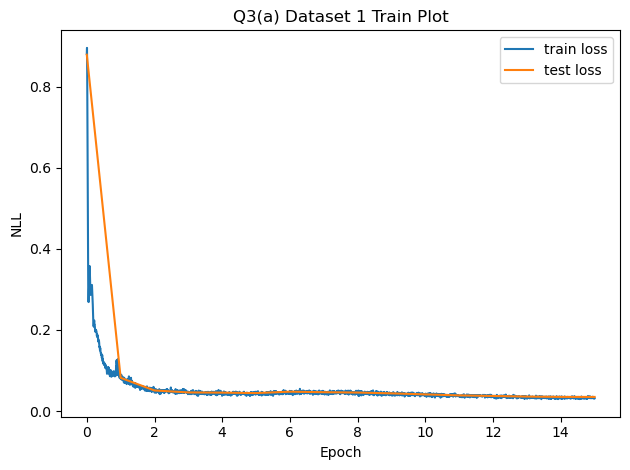

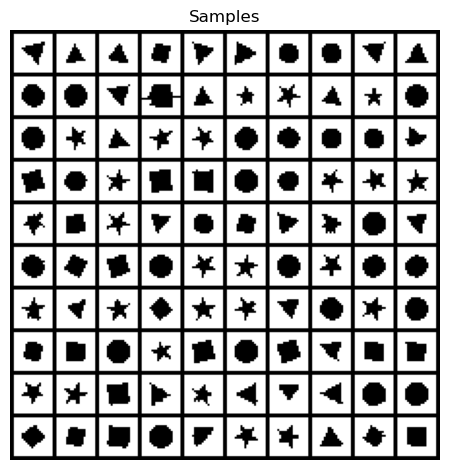

In [65]:
print("Add embeddings")
q3ab_save_results(1, 'a', q3_a)
with torch.no_grad():
    torch.cuda.empty_cache()

Add embeddings
Parameter count: 4.36e+07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [8:20:48<00:00, 2003.24s/it]


Final Test Loss: 0.0792


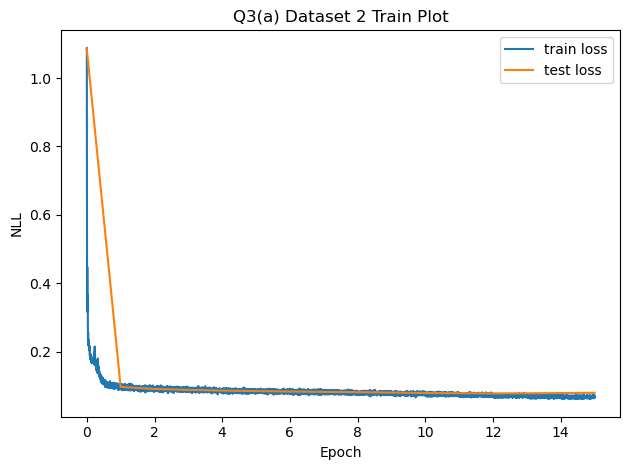

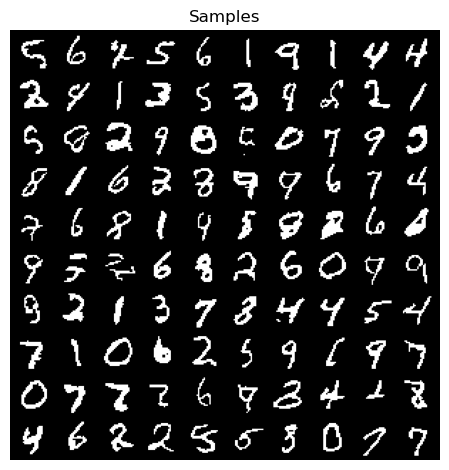

In [66]:
print("Add embeddings")
q3ab_save_results(2, 'a', q3_a)
with torch.no_grad():
    torch.cuda.empty_cache()

In [67]:
make_igpt_model = lambda *args: GPT(*args, concat_embed=True)

Concatenate embeddings
Parameter count: 4.24e+07


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [41:55<00:00, 167.67s/it]


Final Test Loss: 0.1726


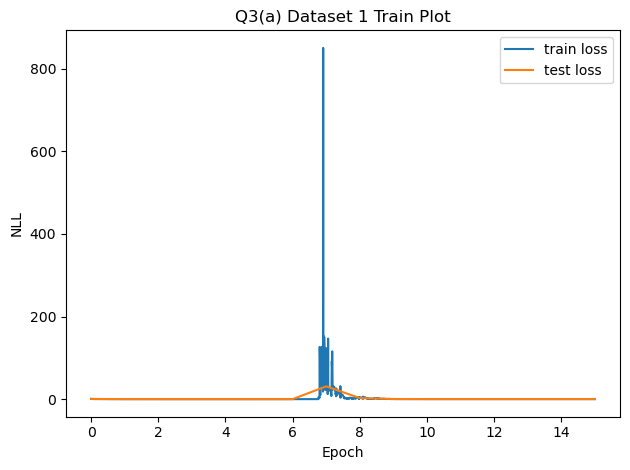

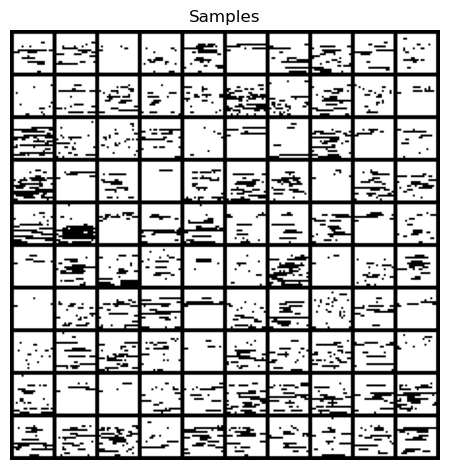

In [68]:
print("Concatenate embeddings")
q3ab_save_results(1, 'a', q3_a)
with torch.no_grad():
    torch.cuda.empty_cache()

Concatenate embeddings
Parameter count: 4.28e+07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [8:21:30<00:00, 2006.05s/it]


Final Test Loss: 0.0791


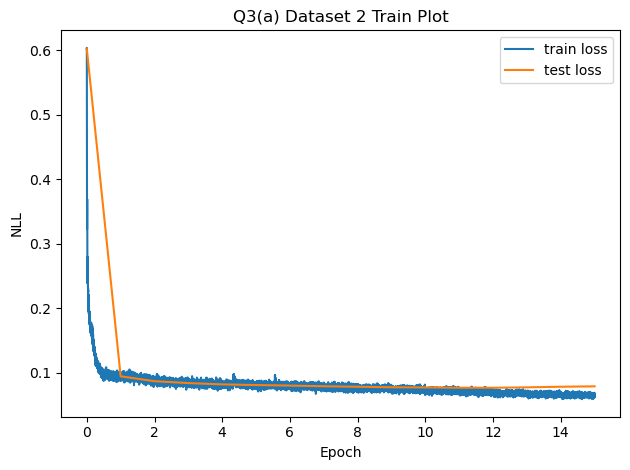

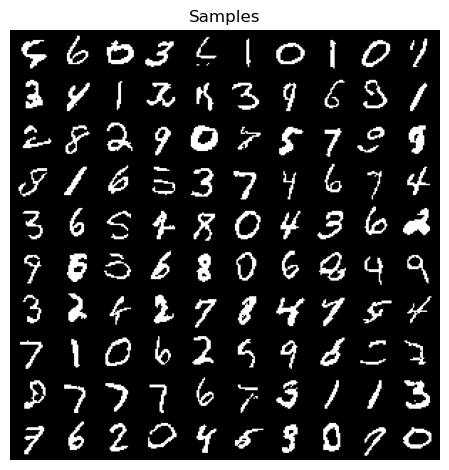

In [69]:
print("Concatenate embeddings")
q3ab_save_results(2, 'a', q3_a)
with torch.no_grad():
    torch.cuda.empty_cache()

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from $H \cdot W \cdot C$ to just $H \cdot W$. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [70]:
train_data, test_data = utils.load_pickled_data("data/shapes_colored.pkl")
print(train_data[:2].squeeze())
print(train_data[:2].shape)

print()
tokenizer = ImageTokenizer(train_data.shape[1:], 4)
tokens = tokenizer.tokenize(train_data[:2])
print(tokens.squeeze())
print(tokens.shape)

print()
x = tokenizer.detokenize(tokens)
print(x.shape)
print((x == train_data[:2]).all())

[[[[1 0 2]
   [1 0 2]
   [1 0 2]
   ...
   [1 0 2]
   [1 0 2]
   [1 0 2]]

  [[1 0 2]
   [1 0 2]
   [1 0 2]
   ...
   [1 0 2]
   [1 0 2]
   [1 0 2]]

  [[1 0 2]
   [1 0 2]
   [1 0 2]
   ...
   [1 0 2]
   [1 0 2]
   [1 0 2]]

  ...

  [[1 0 2]
   [1 0 2]
   [1 0 2]
   ...
   [1 0 2]
   [1 0 2]
   [1 0 2]]

  [[1 0 2]
   [1 0 2]
   [1 0 2]
   ...
   [1 0 2]
   [1 0 2]
   [1 0 2]]

  [[1 0 2]
   [1 0 2]
   [1 0 2]
   ...
   [1 0 2]
   [1 0 2]
   [1 0 2]]]


 [[[2 0 2]
   [2 0 2]
   [2 0 2]
   ...
   [2 0 2]
   [2 0 2]
   [2 0 2]]

  [[2 0 2]
   [2 0 2]
   [2 0 2]
   ...
   [2 0 2]
   [2 0 2]
   [2 0 2]]

  [[2 0 2]
   [2 0 2]
   [2 0 2]
   ...
   [2 0 2]
   [2 0 2]
   [2 0 2]]

  ...

  [[2 0 2]
   [2 0 2]
   [2 0 2]
   ...
   [2 0 2]
   [2 0 2]
   [2 0 2]]

  [[2 0 2]
   [2 0 2]
   [2 0 2]
   ...
   [2 0 2]
   [2 0 2]
   [2 0 2]]

  [[2 0 2]
   [2 0 2]
   [2 0 2]
   ...
   [2 0 2]
   [2 0 2]
   [2 0 2]]]]
(2, 20, 20, 3)

[[64 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18

In [72]:
make_igpt_model = lambda *args: None
save_model = False

def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  pytorch_util.set_gpu_mode("cuda", GPU_ID)
  device = pytorch_util.device
  pytorch_util.seed_rng(0)

  num_values = 4
  tokenizer = ImageTokenizer(image_shape, num_values)
  train_data = tokenizer.tokenize(train_data)
  test_data = tokenizer.tokenize(test_data)
  train_losses, test_losses = [], []

  num_heads, num_layers = 4, 2
  embed_dim = 128*num_heads
  model = make_igpt_model(tokenizer.num_tokens, tokenizer.num_tokens-1, tokenizer.seq_length-1, embed_dim, num_heads, num_layers)
  model.train()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
  test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

  def evaluate():
    model.eval()
    losses = []
    with torch.no_grad():
      for test_mbatch in test_dataloader:
        test_mbatch = test_mbatch.long().to(device)
        logits = model(test_mbatch[:, :-1])
        tgt = test_mbatch[:, 1:]
        loss = F.cross_entropy(logits.reshape(-1, tokenizer.num_tokens-1), tgt.ravel())
        losses.append(loss.cpu().item())
    model.train()
    return np.mean(losses)
  
  test_losses.append(evaluate())
  epochs = 15
  train_steps = epochs * len(train_dataloader)
  scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=train_steps)
  for _ in tqdm(range(epochs)):
    # train loss
    for train_mbatch in train_dataloader:
      train_mbatch = train_mbatch.long().to(device)
      optimizer.zero_grad()
      logits = model(train_mbatch[:, :-1])
      tgt = train_mbatch[:, 1:]
      loss = F.cross_entropy(logits.reshape(-1, tokenizer.num_tokens-1), tgt.ravel())
      loss.backward()
      optimizer.step()
      scheduler.step()
      train_losses.append(loss.cpu().item())

    # test loss
    test_losses.append(evaluate())

  if save_model:
    torch.save(model.state_dict(), "data/igpt_model.pth")

  model.eval()
  samples = tokenizer.detokenize(model.sample(100, tokenizer.num_tokens-1))
    
  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

In [73]:
make_igpt_model = lambda *args: GPT(*args, concat_embed=False)

Add embeddings
Parameter count: 4.31e+07


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [42:08<00:00, 168.57s/it]


Final Test Loss: 0.0525


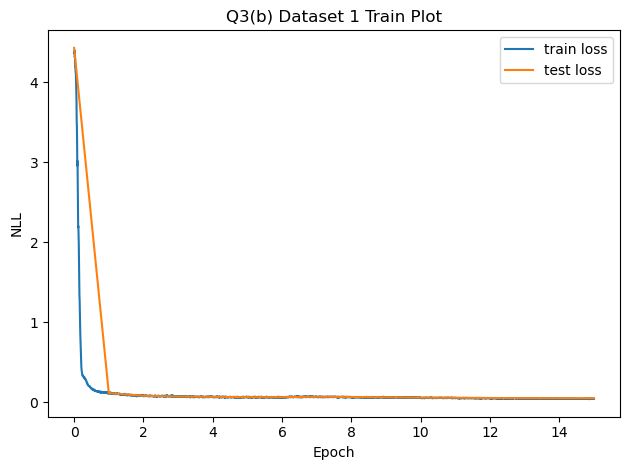

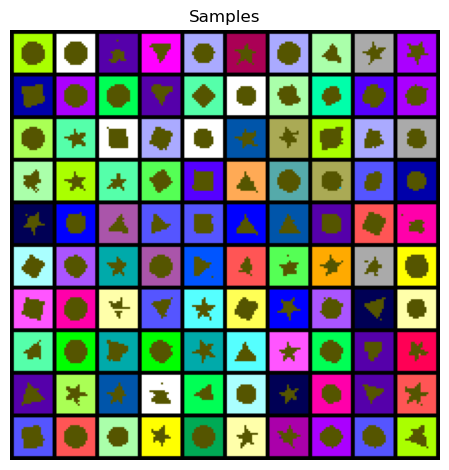

In [74]:
print("Add embeddings")
save_model = False
q3ab_save_results(1, 'b', q3_b)
with torch.no_grad():
    torch.cuda.empty_cache()

Add embeddings
Parameter count: 4.38e+07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [8:21:03<00:00, 2004.25s/it]


Final Test Loss: 0.0942


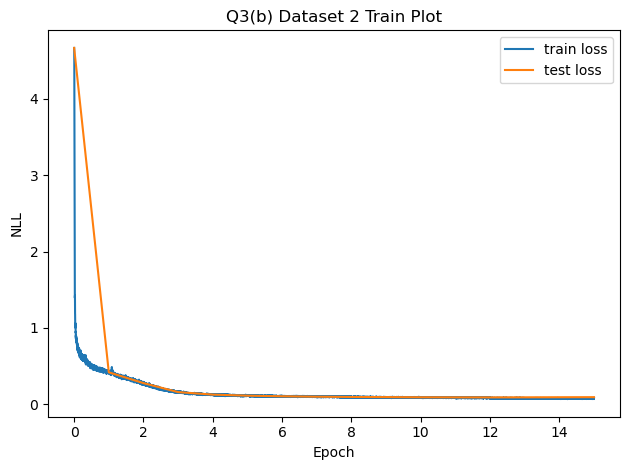

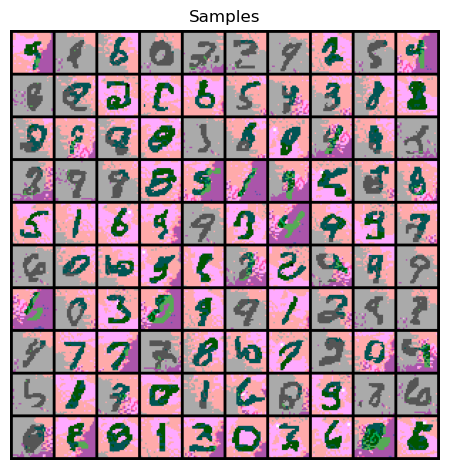

In [75]:
print("Add embeddings")
save_model = True
q3ab_save_results(2, 'b', q3_b)
with torch.no_grad():
    torch.cuda.empty_cache()

In [76]:
make_igpt_model = lambda *args: GPT(*args, concat_embed=True)

Concatenate embeddings
Parameter count: 4.26e+07


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [42:05<00:00, 168.35s/it]


Final Test Loss: 0.0572


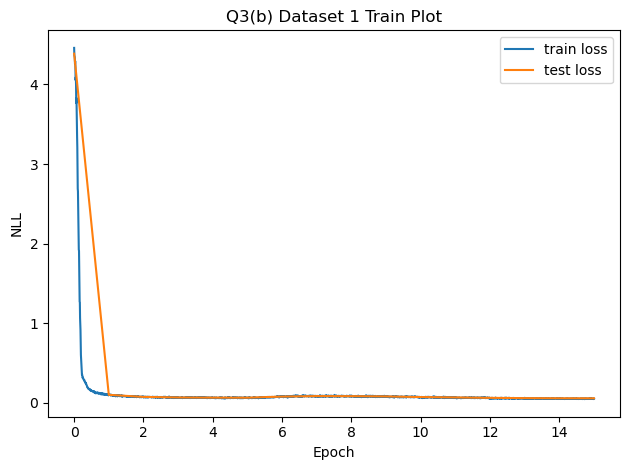

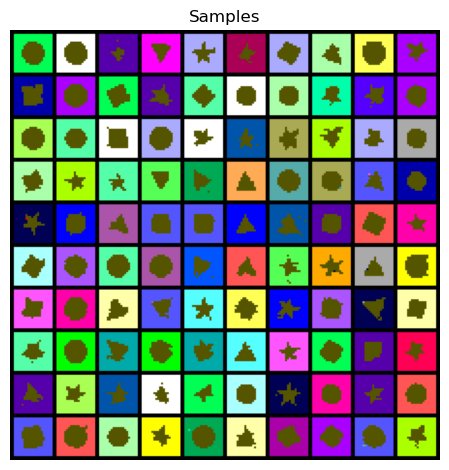

In [77]:
print("Concatenate embeddings")
save_model = False
q3ab_save_results(1, 'b', q3_b)
with torch.no_grad():
    torch.cuda.empty_cache()

Concatenate embeddings
Parameter count: 4.30e+07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [8:20:53<00:00, 2003.58s/it]


Final Test Loss: 0.0932


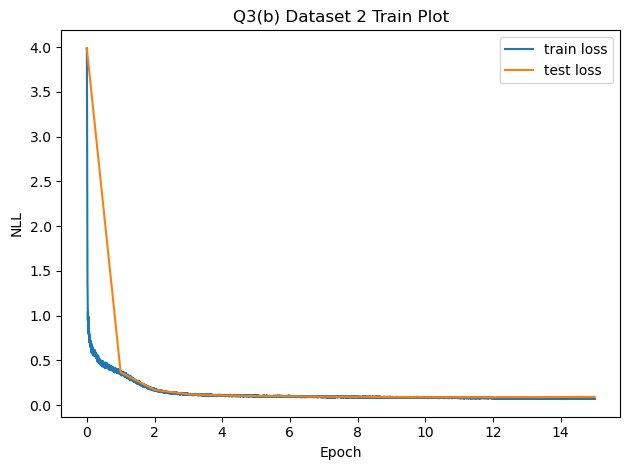

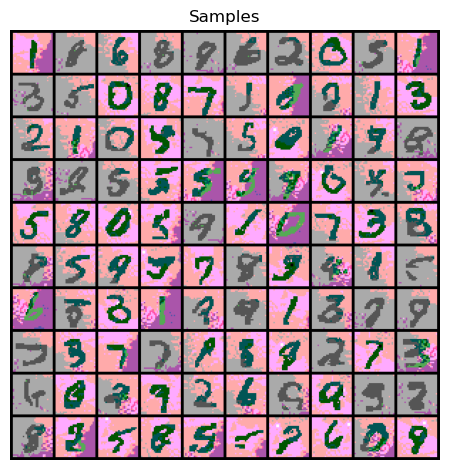

In [78]:
print("Concatenate embeddings")
save_model = False
q3ab_save_results(2, 'b', q3_b)
with torch.no_grad():
    torch.cuda.empty_cache()

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.



In [7]:
def q3_c(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# sampling steps,) numpy array of time per sampling iteration, without caching
    - a (# sampling steps,) numpy array of time per sampling iteration, with caching
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated without caching)
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated with caching)
    """
    pytorch_util.set_gpu_mode("cuda", GPU_ID)
    device = pytorch_util.device

    # tokenizer
    num_values = 4
    tokenizer = ImageTokenizer(image_shape, num_values)

    # model
    num_heads, num_layers = 4, 2
    embed_dim = 128*num_heads
    model = GPT(tokenizer.num_tokens, tokenizer.num_tokens-1, tokenizer.seq_length-1, embed_dim, num_heads, num_layers)
    model.load_state_dict(torch.load("data/igpt_model.pth"))
    model.eval()
    model.to(device)

    # naive sampling
    pytorch_util.seed_rng(0)
    samples, time_list_no_cache = model.sample_naive(100, tokenizer.num_tokens-1, True)
    samples_no_cache = tokenizer.detokenize(samples)

    # sampling with KV cache
    pytorch_util.seed_rng(0)
    samples, time_list_with_cache = model.sample(100, tokenizer.num_tokens-1, True)
    samples_with_cache = tokenizer.detokenize(samples)

    return time_list_no_cache, time_list_with_cache, samples_no_cache, samples_with_cache

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



Parameter count: 4.38e+07


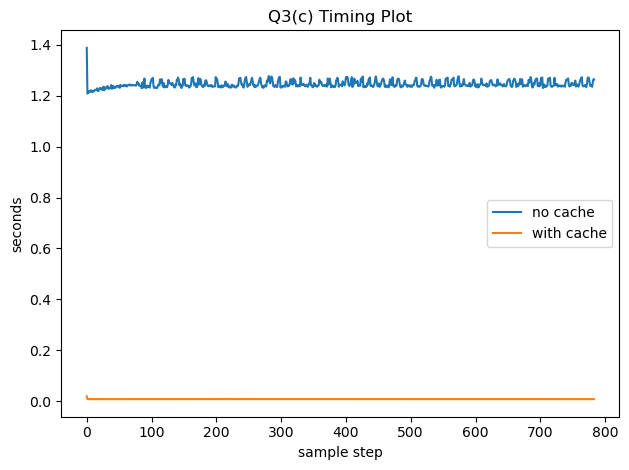

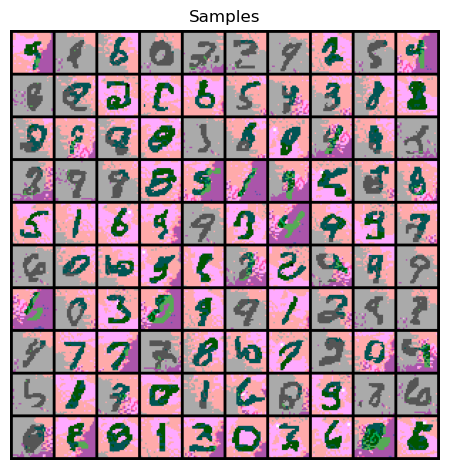

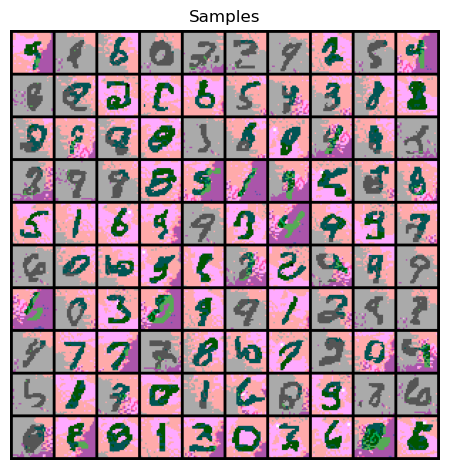

In [8]:
q3c_save_results(2, q3_c)
with torch.no_grad():
    torch.cuda.empty_cache()

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image. 

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience. 

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [81]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#    
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#    
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
# 

In [82]:
def q4_a(images, vqvae):
  """
  images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a numpy array of size (B, H, W, C) of the decoded image
  """
  print("Token vocabulary size:", vqvae.n_embeddings)
  encoded_images = vqvae.quantize(images)
  decoded_images = vqvae.decode(encoded_images)
  return decoded_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Token vocabulary size: 1024


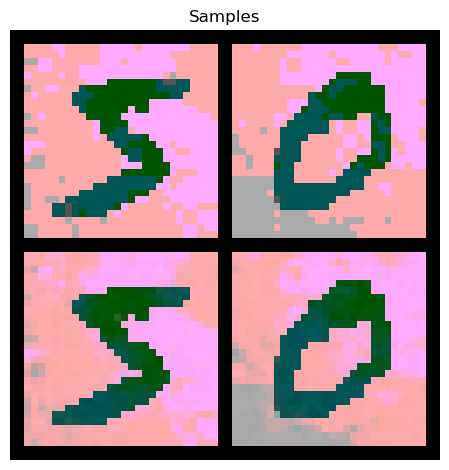

In [83]:
q4a_save_results(1, q4_a)
with torch.no_grad():
    torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Token vocabulary size: 1024


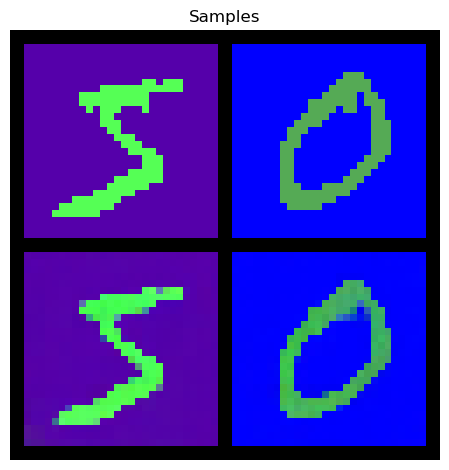

In [84]:
q4a_save_results(2, q4_a)
with torch.no_grad():
    torch.cuda.empty_cache()

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

In [85]:
def q4_b(train_data, test_data, image_shape, dset_id, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets
  vqvae: a vqvae model, trained on dataset dset_id

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
  """
  pytorch_util.set_gpu_mode("cuda", GPU_ID)
  device = pytorch_util.device
  pytorch_util.seed_rng(0)

  encoded_train_data = np.expand_dims(vqvae.quantize(train_data), axis=3)
  encoded_test_data  = np.expand_dims(vqvae.quantize(test_data),  axis=3)

  tokenizer = ImageTokenizer(encoded_train_data.shape[1:], vqvae.n_embeddings)
  tok_train_data = tokenizer.tokenize(encoded_train_data)
  tok_test_data = tokenizer.tokenize(encoded_test_data)
  train_losses, test_losses = [], []

  num_heads, num_layers = 4, 4
  embed_dim = 32*num_heads
  dropout_prob = 0.1
  model = GPT(tokenizer.num_tokens, tokenizer.num_tokens-1, tokenizer.seq_length-1, embed_dim, num_heads, num_layers, dropout_prob=dropout_prob)
  model.train()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  train_dataloader = DataLoader(tok_train_data, batch_size=256, shuffle=True)
  test_dataloader = DataLoader(tok_test_data, batch_size=256, shuffle=False)

  def evaluate():
    model.eval()
    losses = []
    with torch.no_grad():
      for test_mbatch in test_dataloader:
        test_mbatch = test_mbatch.long().to(device)
        logits = model(test_mbatch[:, :-1])
        tgt = test_mbatch[:, 1:]
        loss = F.cross_entropy(logits.reshape(-1, tokenizer.num_tokens-1), tgt.ravel())
        losses.append(loss.cpu().item())
    model.train()
    return np.mean(losses)
  
  test_losses.append(evaluate())
  epochs = 30
  train_steps = epochs * len(train_dataloader)
  scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=train_steps)
  for i in tqdm(range(epochs)):
    # train loss
    for train_mbatch in train_dataloader:
      train_mbatch = train_mbatch.long().to(device)
      optimizer.zero_grad()
      logits = model(train_mbatch[:, :-1])
      tgt = train_mbatch[:, 1:]
      loss = F.cross_entropy(logits.reshape(-1, tokenizer.num_tokens-1), tgt.ravel())
      loss.backward()
      optimizer.step()
      scheduler.step()
      train_losses.append(loss.cpu().item())

    # test loss
    test_losses.append(evaluate())

  model.eval()
  samples = vqvae.decode(tokenizer.detokenize(model.sample(100, tokenizer.num_tokens-1)).squeeze(3))
    
  return train_losses, test_losses, samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



Parameter count: 6.33e+06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [10:02<00:00, 20.09s/it]


Final Test Loss: 2.9390


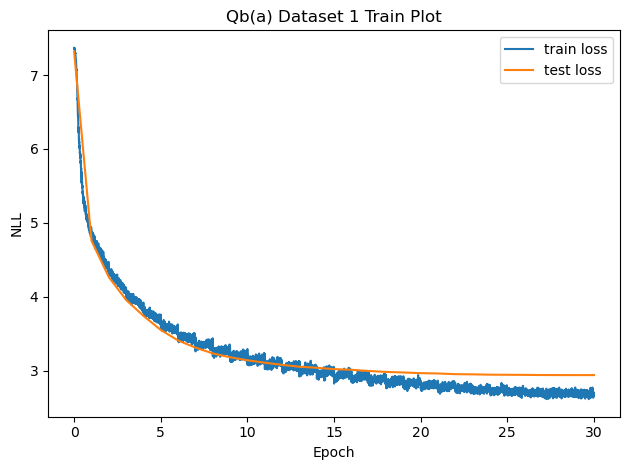

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


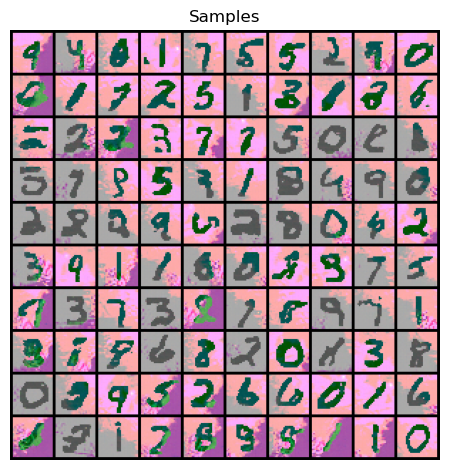

In [86]:
q4b_save_results(1, q4_b)
with torch.no_grad():
    torch.cuda.empty_cache()

Parameter count: 6.33e+06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [10:21<00:00, 20.73s/it]


Final Test Loss: 3.0506


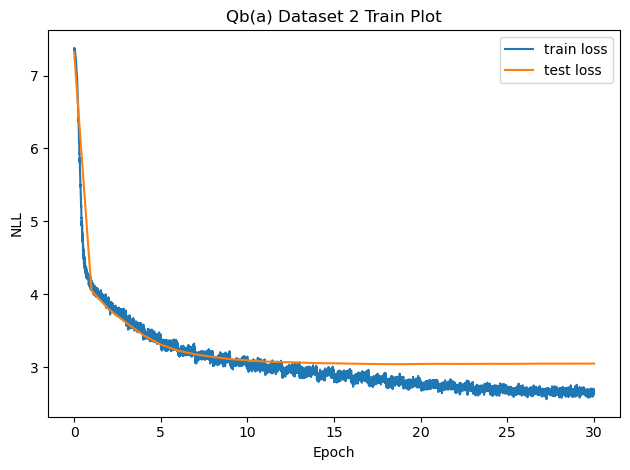

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


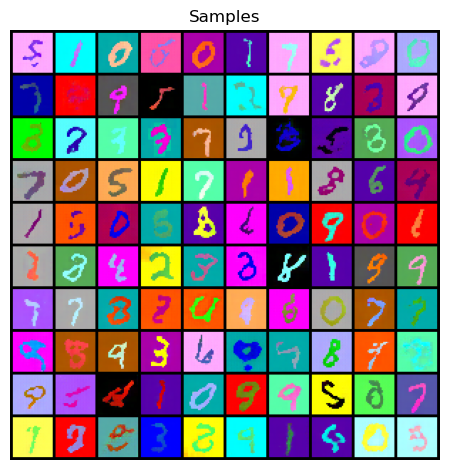

In [87]:
q4b_save_results(2, q4_b)
with torch.no_grad():
    torch.cuda.empty_cache()

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [96]:
visualize_q5_data()

Sample 1
Michael Anania, Afternoons from Selected Poems. Copyright  1994 by Michael Anania. Used by permission of Asphodel Press/Acorn Alliance.
--------------------------------------------------------------------------------

Sample 2
But then there comes that moment rare
When, for no cause that I can find,
The little voices of the air
Sound above all the sea and wind.

The sea and wind do then obey
And sighing, sighing double notes
Of double basses, content to play
A droning chord for the little throats

The little throats that sing and rise
Up into the light with lovely ease
And a kind of magical, sweet surprise
To hear and know themselves for these

For these little voices: the bee, the fly,
The leaf that taps, the pod that breaks,
The breeze on the grass-tops bending by,
The shrill quick sound that the insect makes.
--------------------------------------------------------------------------------

Sample 3
Take all my loves, my love, yea, take them all:
What hast thou then more tha

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [89]:
dir_path = utils.get_data_dir(1)
train_text, _ = load_text_data(osp.join(dir_path, "poetry.pkl"))

In [90]:
print("Number of text snippets:", len(train_text))
print("Number of letters in first snippet:", len(train_text[0]))
chars = sorted(list(set("".join(train_text))))
print("Number of unique characters:", len(chars))
print("Unique characters:", chars)

Number of text snippets: 563
Number of letters in first snippet: 2130
Number of unique characters: 83
Unique characters: ['\n', '\r', ' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}']


In [91]:
class TextTokenizer(Tokenizer):
    def __init__(self, chars):
        self.num_tokens = len(chars)+3
        self.bos = "<BOS>"
        self.eos = "<EOS>"
        self.eos_tok = self.num_tokens-3
        self.bos_tok = self.num_tokens-2
        self.ignore_tok = self.num_tokens-1

        self.stoi = {s: i for i, s in enumerate(chars)}
        self.stoi[self.eos] = self.eos_tok
        self.stoi[self.bos] = self.bos_tok
        self.itos = {i: s for s, i in self.stoi.items()}

    def tokenize(self, list_of_strings):
        list_of_tokens = []
        for string in list_of_strings:
            tokens = [self.bos_tok] + [self.stoi[s] for s in string] + [self.eos_tok]
            list_of_tokens.append(tokens)
        return list_of_tokens

    def detokenize(self, array_of_tokens):
        list_of_strings = []
        for tokens in array_of_tokens:
            chars = []
            for token in tokens:
                if token == self.bos_tok:
                    continue
                if token == self.eos_tok:
                    break
                chars.append(self.itos[token])
            list_of_strings.append(''.join(chars))
        return list_of_strings

In [92]:
tokenizer = TextTokenizer(chars)

In [93]:
train_tokens = tokenizer.tokenize(train_text)

In [94]:
print("Text sample:", train_text[0][:10])
print("Tokenization of text sample:", train_tokens[0][:11])

Text sample: Let the bi
Tokenization of text sample: [84, 37, 59, 74, 2, 74, 62, 59, 2, 56, 63]


In [98]:
class TokenDataset(data.Dataset):
    """
    Represents a dataset of heterogenous-length token sequences.
    """
    def __init__(self, list_of_tokens, seq_length):
        self.seq_length = seq_length
        self.list_of_tokens = [self._pad_and_tensorize(tokens) for tokens in list_of_tokens]
        self.lookup_table = self._make_lookup_table()

    def __len__(self):
        return self.lookup_table.shape[0]

    def __getitem__(self, idx):
        string_idx, start, end = self.lookup_table[idx]
        return self.list_of_tokens[string_idx][start:end]

    def _pad_and_tensorize(self, tokens):
        if len(tokens) < self.seq_length:
            tokens = tokens + (self.seq_length-len(tokens)) * [tokens[-1]+2]
        return torch.tensor(tokens)

    def _make_lookup_table(self):
        """
        idx -> (string_idx, start, end)
        """
        arrays = []
        for string_idx, tokens in enumerate(self.list_of_tokens):
            starts = np.arange(len(tokens)-self.seq_length+1)
            ends = starts + self.seq_length
            arrays.append(np.stack([np.full(len(starts), string_idx), starts, ends], axis=1))
        return np.concatenate(arrays)

In [99]:
dataset = TokenDataset(train_tokens, 128)

In [100]:
snippet_lens = np.array(list(map(len, train_text)))
print("Shortest text snippet length:", snippet_lens.min())
text_idx = snippet_lens.argmin()

Shortest text snippet length: 15


In [101]:
idx = (dataset.lookup_table[:,0] == text_idx).argmax()
print("Corresponding tokenization:")
print(dataset[idx])

Corresponding tokenization:
tensor([84, 60, 72, 69, 67,  2, 29, 55, 68, 55,  9,  2, 14, 22, 13, 17, 83, 85,
        85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85,
        85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85,
        85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85,
        85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85,
        85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85,
        85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85,
        85, 85])


In [102]:
def q5_a(train_text, test_text):
    """
    train_text: list[str] Train text sequences.
    test_text: list[str] Test text sequences.

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 5 (str), 5 generated samples from the model.
    """
    pytorch_util.set_gpu_mode("cuda", GPU_ID)
    device = pytorch_util.device
    pytorch_util.seed_rng(0)

    chars = sorted(list(set("".join(train_text))))
    tokenizer = TextTokenizer(chars)
    train_tokens = tokenizer.tokenize(train_text)
    test_tokens = tokenizer.tokenize(test_text)
    train_losses, test_losses = [], []

    num_heads, num_layers = 4, 2
    embed_dim = 16*num_heads # 32*num_heads
    seq_length = 128
    dropout_prob = 0.1
    model = GPT(tokenizer.num_tokens, tokenizer.num_tokens-2, seq_length-1, embed_dim, num_heads, num_layers, dropout_prob=dropout_prob)
    model.train()
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_dataset = TokenDataset(train_tokens, seq_length)
    test_dataset = TokenDataset(test_tokens, seq_length)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    def evaluate():
        model.eval()
        losses = []
        with torch.no_grad():
            for test_mbatch in test_dataloader:
                test_mbatch = test_mbatch.long().to(device)
                logits = model(test_mbatch[:, :-1])
                tgt = test_mbatch[:, 1:]
                loss = F.cross_entropy(logits.reshape(-1, tokenizer.num_tokens-2), tgt.ravel(), ignore_index=tokenizer.ignore_tok)
                losses.append(loss.cpu().item())
        model.train()
        return np.mean(losses)

    test_losses.append(evaluate())
    epochs = 20 # 10
    train_steps = epochs * len(train_dataloader)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=train_steps)
    for _ in tqdm(range(epochs)):
        # train loss
        for train_mbatch in train_dataloader:
            train_mbatch = train_mbatch.long().to(device)
            optimizer.zero_grad()
            logits = model(train_mbatch[:, :-1])
            tgt = train_mbatch[:, 1:]
            loss = F.cross_entropy(logits.reshape(-1, tokenizer.num_tokens-2), tgt.ravel(), ignore_index=tokenizer.ignore_tok)
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_losses.append(loss.cpu().item())

        # test loss
        test_losses.append(evaluate())

    model.eval()
    token_samples = model.sample(5, tokenizer.num_tokens-2)
    text_samples = tokenizer.detokenize(token_samples)
            
    return train_losses, test_losses, text_samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



Parameter count: 7.35e+05


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [35:13<00:00, 105.67s/it]


Final Test Loss: 1.6300


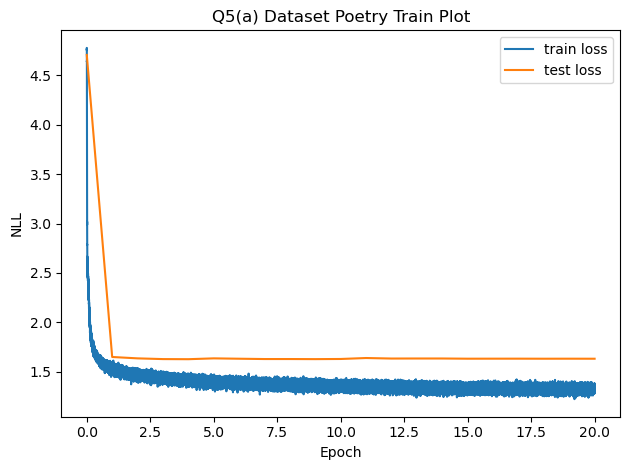

Sample 1
Now fair is perfect my faces white,
I one with black right:
(He heard, that he ball woes to prayses and teare.

What what m

Sample 2
Sigh a cool service, the the Saws."
         " see has from the Mine, every forever;
Who being all I saw the beauty with with

Sample 3
Repressence shorps "arch her and Marc Site."
                                                "The fit for thy?
And sweet thou

Sample 4
Her heart dwells sweet; and that knoweth
Shall think that heaven's time
Fu' a free mind.
The stone and friends, which be dot

Sample 5
Lute the purely in the prights and procented
Till theyr dead friends of delicate.


A great grow old ye a hey speak which i



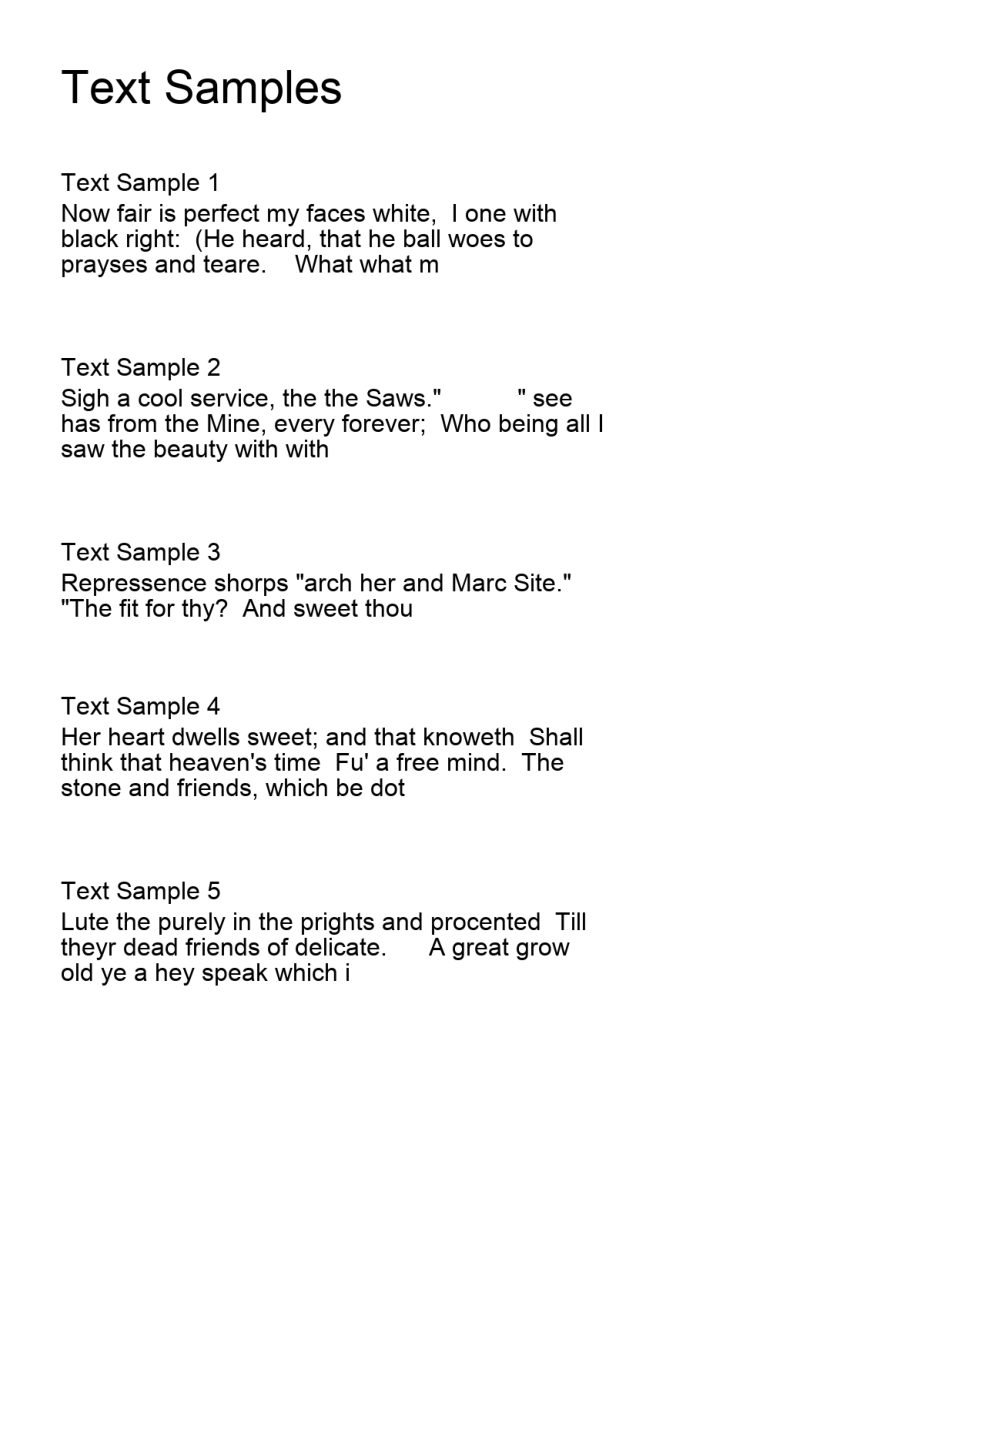

In [103]:
q5a_save_results(q5_a)
with torch.no_grad():
    torch.cuda.empty_cache()

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

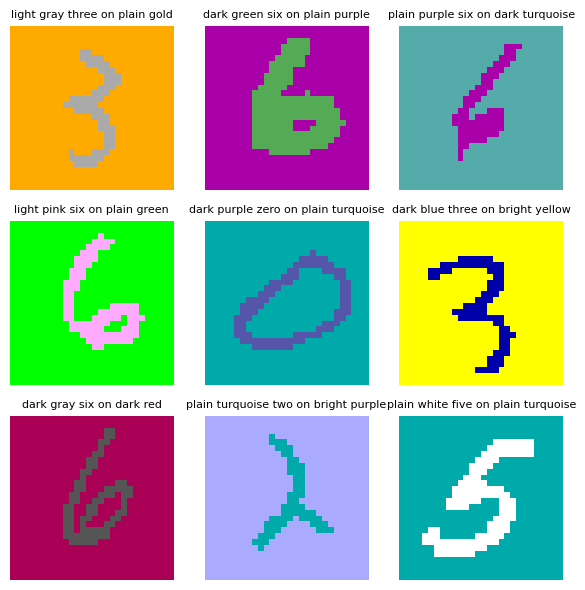

In [104]:
visualize_q6_data()

## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

In [105]:
dir_path = utils.get_data_dir(1)
train_data, _, train_labels, _ = load_colored_mnist_text(osp.join(dir_path, "colored_mnist_with_text.pkl"))

In [106]:
print("Image shape:", train_data.shape)
print("Number of labels:", len(train_labels))
print("Number of words in label:", len(train_labels[0].split(" ")))
print("Image pixel values:", np.unique(train_data))
print(f"First label: \"{train_labels[0]}\"")

Image shape: (60000, 28, 28, 3)
Number of labels: 60000
Number of words in label: 6
Image pixel values: [0 1 2 3]
First label: "light green five on dark magenta"


In [107]:
print("Quantization via VQVAE")
vqvae = load_pretrain_vqvae("colored_mnist_2")
upto = 5
tokenized_images = vqvae.quantize(train_data[:upto])
print("Tokenized image vocabulary size:", vqvae.n_embeddings)
print("Tokenized image shape:", tokenized_images.shape[1:])
print("Tokenized image example:")
print(tokenized_images[0])

Quantization via VQVAE
Tokenized image vocabulary size: 1024
Tokenized image shape: torch.Size([7, 7])
Tokenized image example:
tensor([[288,  75, 641,  75, 907, 907, 288],
        [402, 964, 265, 636, 425, 427, 402],
        [907, 993, 616, 504, 847, 718, 402],
        [ 75, 896, 883, 274, 888, 288, 421],
        [ 75, 641, 964, 419, 432, 421, 421],
        [336, 451, 859, 904, 117, 402, 288],
        [117, 694, 330, 336, 402, 288, 421]])


In [108]:
words = (" ".join(train_labels)).split(" ")
vocab = sorted(list(set(words)))
print("Vocabulary:")
print(vocab)
print("Size of vocabulary:", len(vocab))

Vocabulary:
['black', 'blue', 'bright', 'brown', 'cyan', 'dark', 'eigth', 'five', 'four', 'gold', 'gray', 'green', 'light', 'magenta', 'nine', 'normal', 'on', 'one', 'orange', 'pink', 'plain', 'purple', 'red', 'seven', 'six', 'three', 'turquoise', 'two', 'white', 'yellow', 'zero']
Size of vocabulary: 31


In [9]:
class Q6aTokenizer(Tokenizer):
    def __init__(self, img_size, num_pixel_values, text_length, words):
        """
        img_size: (H, W) tuple
        num_pixel_values: int
        text_length: number of words in text
        words: list of words in vocabulary

        Token description:
        - 0 through num_pixel_values-1 reserved for image tokens
        - num_pixel_values through num_pixel_values+len(words)-1 reserved for word tokens
        - num_pixel_values+len(words)   reserved for <start of image>
        - num_pixel_values+len(words)+1 reserved for <start of text>
        - num_pixel_values+len(words)+2 reserved for <bos>
        """
        self.num_token_values = num_pixel_values + len(words) + 3
        self.bos = "<BOS>"
        self.soi = "<SOI>"
        self.sot = "<SOT>"
        self.soi_tok = self.num_token_values-3
        self.sot_tok = self.num_token_values-2
        self.bos_tok = self.num_token_values-1

        # image
        self.H, self.W = img_size
        self.num_pixel_values = num_pixel_values
        self.num_img_tokens = self.H*self.W + 1  # one extra token for <start of image>

        # label
        self.text_length = text_length
        self.num_text_tokens = self.text_length + 1  # one extra token for <start of text>
        self.vocab_size = len(words)
        self.stoi = {s: i+num_pixel_values for i, s in enumerate(words)}
        self.stoi[self.bos] = self.bos_tok
        self.stoi[self.soi] = self.soi_tok
        self.stoi[self.sot] = self.sot_tok
        self.itos = {i: s for s, i in self.stoi.items()}

        # bounds
        self.first_img_tok = 0
        self.last_img_tok = self.first_img_tok + self.num_pixel_values-1
        self.first_text_tok = self.num_pixel_values
        self.last_text_tok = self.first_text_tok + self.vocab_size-1

        self.num_tokens = self.num_img_tokens + self.num_text_tokens + 1  # one extra token for <bos>

    def tokenize_image(self, img: np.ndarray) -> np.ndarray:
        """
        img: (batch, H, W) array

        Returns
        - (batch, H*W+1) array
        """
        B, H, W = img.shape
        assert H == self.H
        assert W == self.W
        tokens = np.empty([B, self.num_img_tokens], dtype=np.int64)
        tokens[:, 0] = self.soi_tok  # <start of image>
        tokens[:, 1:] = img.reshape(B, -1)
        return tokens

    def detokenize_image(self, tok: np.ndarray) -> np.ndarray:
        """
        tok: (batch, H*W+1) array

        Returns
        - (batch, H, W) array
        """
        tok = tok[:, 1:]  # remove any "prompt" tokens
        return tok.reshape(tok.shape[0], self.H, self.W)

    def tokenize_text(self, list_of_strings):
        B = len(list_of_strings)
        tokens = np.empty([B, self.num_text_tokens], dtype=np.int64)
        tokens[:, 0] = self.sot_tok  # <start of text>
        for i, label in enumerate(list_of_strings):
            tokens[i, 1:] = np.array([self.stoi[s] for s in label.split(" ")])
        return tokens

    def detokenize_text(self, tokens):
        list_of_strings = []
        tokens = tokens[:, 1:]  # remove any "prompt" tokens
        for toks in tokens:
            words = [self.itos[tok] for tok in toks]
            list_of_strings.append(" ".join(words))
        return list_of_strings

    def detokenize(self, tokens):
        """
        `tokens` represents an array of multimodal tokens, i.e., mix of
        (<bos>, img, text) and (<bos>, text, img)
        """
        B = tokens.shape[0]

        # text
        text_tokens = tokens[(tokens == self.sot_tok) | ((tokens >= self.first_text_tok) & (tokens <= self.last_text_tok))]
        text_tokens = text_tokens.reshape(B, self.num_text_tokens)
        text = self.detokenize_text(text_tokens)

        # image
        img_tokens = tokens[(tokens == self.soi_tok) | ((tokens >= self.first_img_tok) & (tokens <= self.last_img_tok))]
        img_tokens = img_tokens.reshape(B, self.num_img_tokens)
        img = self.detokenize_image(img_tokens)

        return img, text

In [110]:
tokenizer = Q6aTokenizer(tokenized_images.shape[1:], vqvae.n_embeddings, len(train_labels[0].split(" ")), vocab)
img_tokens = tokenizer.tokenize_image(tokenized_images)
text_tokens = tokenizer.tokenize_text(train_labels[:upto])
print("Number of tokens:", tokenizer.num_token_values)

Number of tokens: 1058


In [111]:
print("Image token shape:", img_tokens.shape)
print("Text token shape:", text_tokens.shape)

Image token shape: (5, 50)
Text token shape: (5, 7)


In [112]:
print("Example image tokens:")
print(img_tokens)

Example image tokens:
[[1055  288   75  641   75  907  907  288  402  964  265  636  425  427
   402  907  993  616  504  847  718  402   75  896  883  274  888  288
   421   75  641  964  419  432  421  421  336  451  859  904  117  402
   288  117  694  330  336  402  288  421]
 [1055  334  779  334  226  637  779  242  637  950  132  914  922  802
   779  179  253  651  167  937  713  779  779  675  231  132  179  939
   253  779  928  380  435  369  136  468  779  928  939  859  211  625
   637  779  334  309  435  242  468  637]
 [1055  500  269  269  544  269  769  269  872  376  459  269  219  714
   459  154  237  459  500  772  262  269  784    2  566  651  660  440
   459  480  531  145  508  752  269  500  769  749  769  722  517  121
   459  500  500  269  884   25  500  269]
 [1055  306  306  306  484  306  306  306  974  306  306  306  857  265
   306  306  306  306  315  376  887  306  306  306  752  728  782  974
   306  306  974  714  250  306  306  306  306  306  690 

In [113]:
print("Example text tokens:")
print(text_tokens)

Example text tokens:
[[1056 1036 1035 1031 1040 1029 1037]
 [1056 1029 1035 1054 1040 1044 1025]
 [1056 1029 1035 1032 1040 1044 1037]
 [1056 1029 1050 1041 1040 1029 1045]
 [1056 1036 1034 1038 1040 1036 1043]]


In [114]:
combined_tokens = np.concatenate([
    np.full((upto, 1), tokenizer.bos_tok),
    img_tokens,
    text_tokens
], axis=1)

print("Image+text token shape:", combined_tokens.shape)
print()
print("Example image+text tokens:")
print(combined_tokens)

Image+text token shape: (5, 58)

Example image+text tokens:
[[1057 1055  288   75  641   75  907  907  288  402  964  265  636  425
   427  402  907  993  616  504  847  718  402   75  896  883  274  888
   288  421   75  641  964  419  432  421  421  336  451  859  904  117
   402  288  117  694  330  336  402  288  421 1056 1036 1035 1031 1040
  1029 1037]
 [1057 1055  334  779  334  226  637  779  242  637  950  132  914  922
   802  779  179  253  651  167  937  713  779  779  675  231  132  179
   939  253  779  928  380  435  369  136  468  779  928  939  859  211
   625  637  779  334  309  435  242  468  637 1056 1029 1035 1054 1040
  1044 1025]
 [1057 1055  500  269  269  544  269  769  269  872  376  459  269  219
   714  459  154  237  459  500  772  262  269  784    2  566  651  660
   440  459  480  531  145  508  752  269  500  769  749  769  722  517
   121  459  500  500  269  884   25  500  269 1056 1029 1035 1032 1040
  1044 1037]
 [1057 1055  306  306  306  484  306 

In [115]:
img, text = tokenizer.detokenize(combined_tokens)
print("Detokenized text:")
print(text)

print()
print("Detokenized, encoded image:")
print(img[0])

Detokenized text:
['light green five on dark magenta', 'dark green zero on plain blue', 'dark green four on plain magenta', 'dark turquoise one on dark purple', 'light gray nine on light pink']

Detokenized, encoded image:
[[288  75 641  75 907 907 288]
 [402 964 265 636 425 427 402]
 [907 993 616 504 847 718 402]
 [ 75 896 883 274 888 288 421]
 [ 75 641 964 419 432 421 421]
 [336 451 859 904 117 402 288]
 [117 694 330 336 402 288 421]]


In [10]:
class Q6aDataset(data.Dataset):
    def __init__(self, image_tokens: torch.Tensor, label_tokens: torch.Tensor, bos_token: int):
        assert image_tokens.shape[0] == label_tokens.shape[0]
        self.image_tokens = image_tokens
        self.label_tokens = label_tokens

        B, L_i = image_tokens.shape
        _, L_t = label_tokens.shape

        self.tokens = torch.empty(2*B, L_i+L_t+1, dtype=torch.int64)
        self.tokens[:, 0] = bos_token
        self.tokens[:B, 1:L_i+1] = self.image_tokens
        self.tokens[:B, -L_t:]   = self.label_tokens
        self.tokens[B:, 1:L_t+1] = self.label_tokens
        self.tokens[B:, -L_i:]   = self.image_tokens

    def __len__(self):
        return self.tokens.shape[0]

    def __getitem__(self, idx):
        return self.tokens[idx]

    @property
    def seq_length(self):
        return self.tokens.shape[1]

In [117]:
dataset = Q6aDataset(torch.from_numpy(img_tokens), torch.from_numpy(text_tokens), tokenizer.bos_tok)

In [118]:
print("Number of data points in example dataset:", len(dataset))

Number of data points in example dataset: 10


In [119]:
print("Example data point:")
print(dataset[0])

Example data point:
tensor([1057, 1055,  288,   75,  641,   75,  907,  907,  288,  402,  964,  265,
         636,  425,  427,  402,  907,  993,  616,  504,  847,  718,  402,   75,
         896,  883,  274,  888,  288,  421,   75,  641,  964,  419,  432,  421,
         421,  336,  451,  859,  904,  117,  402,  288,  117,  694,  330,  336,
         402,  288,  421, 1056, 1036, 1035, 1031, 1040, 1029, 1037])


In [11]:
class Q6aGPT(GPT):
    def __init__(
        self,
        tokenizer: Q6aTokenizer,
        seq_length: int,
        embed_dim: int,
        num_heads: int,
        num_layers: int,
        dropout_prob: float = 0.,
        concat_embed: bool = False
    ):
        super().__init__(
            tokenizer.num_token_values,
            tokenizer.num_token_values-1,
            seq_length,
            embed_dim,
            num_heads,
            num_layers,
            dropout_prob,
            concat_embed
        )

        self.sot_tok = tokenizer.sot_tok
        token_range = torch.arange(self.num_pred_tokens)
        img_mask = ~(token_range < tokenizer.num_pixel_values)
        text_mask = ~((token_range < tokenizer.num_pixel_values+tokenizer.vocab_size) & img_mask)
        soi_mask = ~(token_range == tokenizer.num_pixel_values+tokenizer.vocab_size)
        sot_mask = ~(token_range == tokenizer.num_pixel_values+tokenizer.vocab_size+1)
        mode_select_mask = soi_mask & sot_mask

        text_then_img_mask = torch.stack([
            mode_select_mask,
            *((tokenizer.num_text_tokens-1) * [text_mask]),
            soi_mask,
            *((tokenizer.num_img_tokens-1) * [img_mask])
        ])
        img_then_text_mask = torch.stack([
            mode_select_mask,
            *((tokenizer.num_img_tokens-1) * [img_mask]),
            sot_mask,
            *((tokenizer.num_text_tokens-1) * [text_mask])
        ])
        self.register_buffer("text_then_img_mask", text_then_img_mask)
        self.register_buffer("img_then_text_mask", img_then_text_mask)

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        logits = super().forward(tokens)

        text_then_img = (tokens[:, 1] == self.sot_tok)  # (B,)
        img_then_text = ~text_then_img                  # (B,)
        logits.masked_fill_(text_then_img[:, None, None] & self.text_then_img_mask, -torch.inf)
        logits.masked_fill_(img_then_text[:, None, None] & self.img_then_text_mask, -torch.inf)
        
        return logits
        
    def sample(
        self,
        n_samples: int,
        tokenizer: Q6aTokenizer
    ):
        prompt = torch.full((n_samples, 1), tokenizer.bos_tok, device=self.device, dtype=torch.long)
        return self.sample_from_prompt(prompt, tokenizer)


    def sample_from_prompt(
        self,
        prompt: torch.Tensor,
        tokenizer: Q6aTokenizer
    ):
        B, L = prompt.shape
        with torch.no_grad():
            samples = torch.zeros(B, self.seq_length+1, device=self.device, dtype=torch.long)
            samples[:, :L] = prompt
            for i in range(L-1, self.seq_length):
                logits = self(samples[:, :self.seq_length])[:, i]                    # (n_samples, T-1)
                self._mask_logits(logits, samples, i, tokenizer)
                probs = F.softmax(logits, 1)                                         # (n_samples, T-1)
                sampled_tokens = torch.multinomial(probs, num_samples=1).squeeze(1)  # (n_samples,)
                samples[:, i+1] = sampled_tokens
        return samples.cpu().numpy()

    def _mask_logits(
        self,
        logits: torch.Tensor,
        samples: torch.Tensor,
        idx: int,
        tokenizer: Q6aTokenizer
    ):
        if idx == 0:  # selecting mode
            logits[:, self.text_then_img_mask[idx]] = float("-inf")
            return

        text_then_img_mode = (samples[:, 1] == tokenizer.sot_tok)  # (n_samples,)
        img_then_text_mode = ~text_then_img_mode                   # (n_samples,)

        logits[text_then_img_mode.unsqueeze(1) & self.text_then_img_mask[idx]] = float("-inf")
        logits[img_then_text_mode.unsqueeze(1) & self.img_then_text_mask[idx]] = float("-inf")

        first_text_mode = (samples[:, 1] == tokenizer.sot_tok)
        first_img_mode = ~first_text_mode

In [13]:
def q6_a(train_data, test_data, image_shape, train_text, test_text, image_test_prompt, text_test_prompt, vqvae):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
    train_text: list[str] Text data associated with each training image.
    test_text: list[str] Text data associated with each test image.
    image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
    text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
    vqvae: a vqvae model, trained on the relevant dataset

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 9 (image, text), corresponding to the image conditioned samples
    - a list of 9 (image, text), corresponding to the text conditions samples
    - a list of 9 (image, text), corresponding to unconditional samples
    """
    pytorch_util.set_gpu_mode("cuda", GPU_ID)
    device = pytorch_util.device
    pytorch_util.seed_rng(0)

    # images
    #train_data, test_data = train_data[:upto], test_data[:upto]
    encoded_train_data = vqvae.quantize(train_data)
    encoded_test_data  = vqvae.quantize(test_data)
    encoded_image_shape = encoded_train_data.shape[1:]

    # text
    words = (" ".join(train_text)).split(" ")
    vocab = sorted(list(set(words)))
    text_length = len(train_text[0].split(" "))
    #train_text, test_text = train_text[:upto], test_text[:upto]

    tokenizer = Q6aTokenizer(encoded_image_shape, vqvae.n_embeddings, text_length, vocab)
    train_img_tokens = torch.from_numpy(tokenizer.tokenize_image(encoded_train_data))
    train_text_tokens = torch.from_numpy(tokenizer.tokenize_text(train_text))
    test_img_tokens = torch.from_numpy(tokenizer.tokenize_image(encoded_test_data))
    test_text_tokens = torch.from_numpy(tokenizer.tokenize_text(test_text))

    train_dataset = Q6aDataset(train_img_tokens, train_text_tokens, tokenizer.bos_tok)
    test_dataset = Q6aDataset(test_img_tokens, test_text_tokens, tokenizer.bos_tok)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    num_heads, num_layers = 4, 4 #2
    embed_dim = 32*num_heads # 64*num_heads
    dropout_prob = 0.1
    model = Q6aGPT(
        tokenizer,
        train_dataset.seq_length-1,
        embed_dim,
        num_heads,
        num_layers,
        dropout_prob=dropout_prob
    )
    model.train()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def evaluate():
        model.eval()
        losses = []
        with torch.no_grad():
            for test_mbatch in test_dataloader:
                test_mbatch = test_mbatch.long().to(device)
                logits = model(test_mbatch[:, :-1])
                tgt = test_mbatch[:, 1:]
                loss = F.cross_entropy(logits.reshape(-1, model.num_pred_tokens), tgt.ravel())
                losses.append(loss.cpu().item())
        model.train()
        return np.mean(losses)

    train_losses, test_losses = [], []
    test_losses.append(evaluate())
    epochs = 30
    train_steps = epochs * len(train_dataloader)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=train_steps)
    for i in tqdm(range(epochs)):
        # train loss
        for train_mbatch in train_dataloader:
            train_mbatch = train_mbatch.long().to(device)
            optimizer.zero_grad()
            logits = model(train_mbatch[:, :-1])
            tgt = train_mbatch[:, 1:]
            loss = F.cross_entropy(logits.reshape(-1, model.num_pred_tokens), tgt.ravel())
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_losses.append(loss.cpu().item())

        # test loss
        test_losses.append(evaluate())

    torch.save(model.state_dict(), "data/multimodal_gpt.pth")

    model.eval()
    num_samples = 9
    
    # image-conditioned sampling
    encoded_image_prompt = vqvae.quantize(image_test_prompt)
    image_prompt_tokens = torch.from_numpy(tokenizer.tokenize_image(encoded_image_prompt)).to(device)
    prompt = torch.empty(num_samples, image_prompt_tokens.shape[1]+1, dtype=torch.int64, device=device)
    prompt[:, 0] = tokenizer.bos_tok
    prompt[:, 1:] = image_prompt_tokens
    image_conditioned_samples = model.sample_from_prompt(prompt, tokenizer)
    _, text_samples = tokenizer.detokenize(image_conditioned_samples)
    samples_image_conditioned = [(img, text) for img, text in zip(image_test_prompt, text_samples)]

    # text-conditioned sampling
    text_prompt_tokens = torch.from_numpy(tokenizer.tokenize_text(text_test_prompt)).to(device)
    prompt = torch.empty(num_samples, text_prompt_tokens.shape[1]+1, dtype=torch.int64, device=device)
    prompt[:, 0] = tokenizer.bos_tok
    prompt[:, 1:] = text_prompt_tokens
    text_conditioned_samples = model.sample_from_prompt(prompt, tokenizer)
    encoded_img_samples, _ = tokenizer.detokenize(text_conditioned_samples)
    img_samples = vqvae.decode(encoded_img_samples)
    samples_text_conditioned = [(img, text) for img, text in zip(img_samples, text_test_prompt)]

    # unconditioned sampling
    unconditioned_samples = model.sample(num_samples, tokenizer)
    encoded_img_samples, text_samples = tokenizer.detokenize(unconditioned_samples)
    img_samples = vqvae.decode(encoded_img_samples)
    samples_unconditioned = [(img, text) for img, text in zip(img_samples, text_samples)]
    
    return train_losses, test_losses, samples_image_conditioned, samples_text_conditioned, samples_unconditioned

### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



Parameter count: 6.37e+06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [28:24<00:00, 56.83s/it]


Final Test Loss: 2.6169


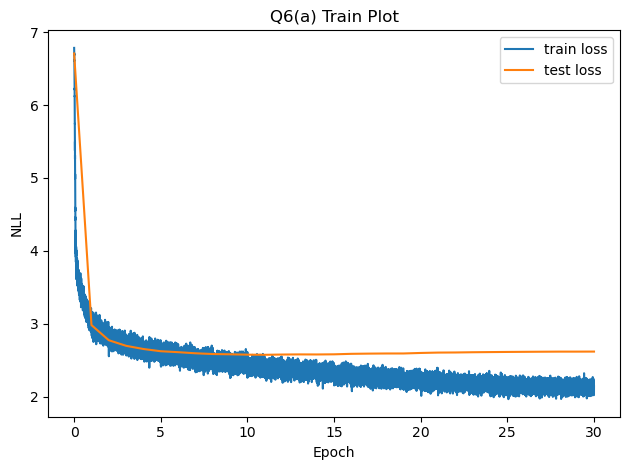

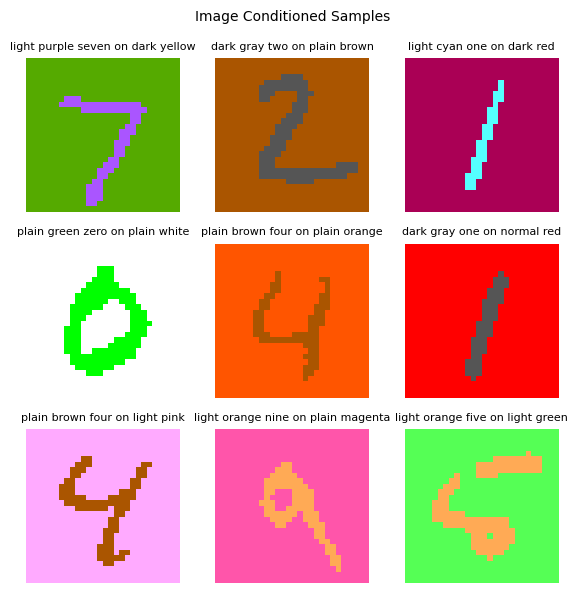

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


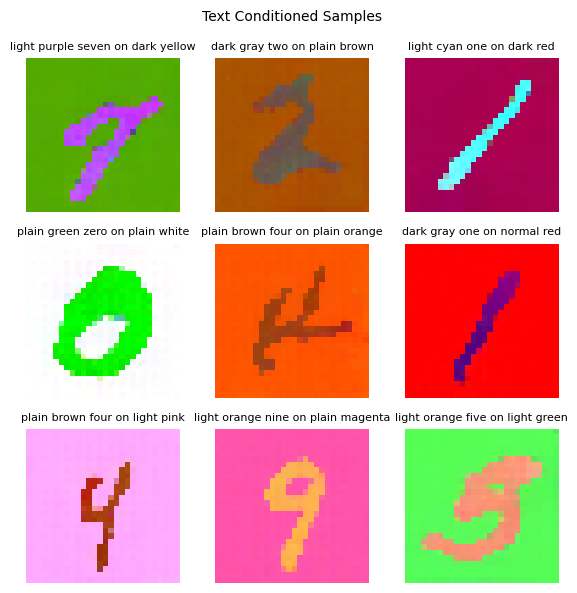

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


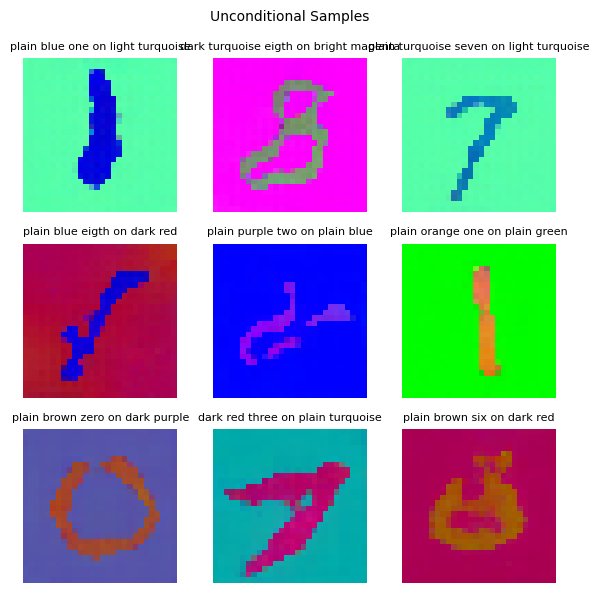

In [14]:
q6a_save_results(q6_a)
with torch.no_grad():
    torch.cuda.empty_cache()